$\color{red}{\text{EDA bien, pour les scatterplot pensez à sns.pairplot() de Seaborn -> matrice de scatterplots.}}$
$\color{red}{\text{POur knn: hold-out et k-fold pourraient être sur le même plot (côte à côte pour chaque k) mais sinon super!}}$
$\color{red}{\text{J'adore l' utilisation d'un loader pour les trucs longs !}}$


## Labo_4 - ISD - Alexis Martins & Arnaud Monition

#### Sites web utilisés pour la réalisation du labo

http://archive.ics.uci.edu/ml/datasets/Wine?Quality

https://www.stat4decision.com/fr/le-box-plot-ou-la-fameuse-boite-a-moustache/

https://gayerie.dev/docs/python/python3/dict.html#:~:text=Un%20dictionnaire

https://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/


## Fonctions et imports

In [1]:
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
import numpy as np
import random
from pprint import pprint
from math import sqrt
from random import randrange
from random import shuffle

In [2]:
# Create a notebook and generate a dataframe
# Separate attributs in another array
pd.set_option('display.max_rows', None)
header_list = ["Class", "Alcohol", "Malic acid","Ash","Alcalinity of ash","Magnesium","Total phenols","Flavanoids","Nonflavanoid phenols","Proanthocyanins","Color intensity","Hue","OD280/OD315 of diluted wines","Proline"]
dataset = pd.read_csv("wine.data", sep=",", names=header_list)

In [3]:
# Function returning three differents classes in the dataframe
def getClasses(df):
    class1 = df[df['Class'] == 1]
    class2 = df[df['Class'] == 2]
    class3 = df[df['Class'] == 3]
    return class1,class2,class3

def show_statistics(truePositive,trueNegative):
    print(" - True Positive : ",truePositive)
    print(" - True Negative : " ,trueNegative)
    accuracy = float("{:.2f}".format(truePositive / (truePositive + trueNegative)  * 100))

    print(" - Accuracy : ",accuracy,'%',"\n")  

#----------------------------------------------------------------
#                         k-NN functions
#---------------------------------------------------------------- 

# calculate the Euclidean distance between two vectors
def euclidean_distance(row1, row2):
    distance = 0.0
    for i in range(len(row1)-1):
        distance += (row1[i] - row2[i])**2
    return sqrt(distance)

# Locate the most similar neighbors
def get_neighbors(train, test_row, num_neighbors):
    distances = list()
    for train_row in train:
        dist = euclidean_distance(test_row, train_row)
        distances.append((train_row, dist))
    distances.sort(key=lambda tup: tup[1])
    neighbors = list()
    for i in range(num_neighbors):
        neighbors.append(distances[i][0])
    return neighbors

# Make a classification prediction with neighbors
def predict_classification(train, test_row, num_neighbors):
    neighbors = get_neighbors(train, test_row, num_neighbors)
    output_values = [row[0] for row in neighbors]
    prediction = max(set(output_values), key=output_values.count)
    return prediction

# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

# Split a dataset into a train and test set
def train_test_split(dataset, split=0.60):
    train = list()
    train_size = split * len(dataset)
    dataset_copy = list(dataset)
    while len(train) < train_size:
        index = randrange(len(dataset_copy))
        train.append(dataset_copy.pop(index))
    return train, dataset_copy

# Split a dataset into n folds
def cross_validation_split(dataset, n_folds):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / n_folds)
    for _ in range(n_folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

# Return results for the accuracy
def calculate_accuracy(train, test, actual, k, cross=False):
    results = []
    predicted = []
    #For all data
    for i in range(len(test)):
        predicted.append(predict_classification(train, test[i], k))
    results.append(accuracy_metric(actual, predicted))
    # This condition permits to return predicted in case we want to use n-folds. This array will be used in evaluate_algorithm_cross
    if cross:
        return predicted
    return results

# Plot a confusion matrics based on actual et predicted datas
def plot_confusion_matrix(actual, predicted, current_plot, axs):
    m = sk.confusion_matrix(actual, predicted)
    disp = sk.ConfusionMatrixDisplay(m, display_labels=['1', '2', '3'])
    disp.plot(ax=axs[current_plot])
    disp.im_.colorbar.remove()
    disp.ax_.set_title(f"fold = {current_plot + 1}")

# This function will evaluate the accuracy of a n-fold validation. PLus we can chose if we want to plot or not the confusion matrix related.
# Note : This function is from machinelearningmastery.com, we only edited it to match our requirements
def evaluate_algorithm_cross(dataset, n_folds, k_to_test, plot_matrix=False):
    
    if plot_matrix:
        fig, axs = plt.subplots(ncols=n_folds, figsize=(20, 5))
        
    folds = cross_validation_split(dataset, n_folds)
    scores = list()
    
    for index, fold in enumerate(folds):
        train_set = list(folds)
        train_set.remove(fold)
        train_set = sum(train_set, [])
        test_set = list()
        for row in fold:
            row_copy = list(row)
            row_copy[-1] = None
            test_set.append(row_copy)
        predicted = calculate_accuracy(train_set, test_set, [wines[0] for wines in test_set],k_to_test, True)
        actual = [row[0] for row in fold]
        
        if plot_matrix:
            plot_confusion_matrix(actual, predicted, index, axs)
            
        accuracy = accuracy_metric(actual, predicted)
        scores.append(accuracy)
        
    if plot_matrix:
        plt.show()
        
    return scores

def plot_accuracy_bar(title, k_to_test, accuracies_mean):
    df = pd.DataFrame({'k':k_to_test, 'accuracy':accuracies_mean})
    plot = df.plot.bar(x='k',y='accuracy', rot=0, figsize=(20, 8), color="#000080",alpha=0.6, edgecolor="black")
    plot.set_title(title)
    plot.set_xlabel('k')
    plot.set_ylabel("Accuracy (%)")
    plot.set_ylim([0,100])
    plot.set_facecolor(('#B5B2B2'))
    plt.show()

#----------------------------------------------------------------
#                            LVQ functions
#---------------------------------------------------------------- 

random.seed(1337)

# Locate the best matching unit
def get_best_matching_unit(codebook, test_row):
    distances = list()
    for codevector in codebook:
        dist = euclidean_distance(codevector, test_row)
        distances.append((codevector, dist))
    distances.sort(key=lambda tup: tup[1])
    return distances[0][0]

# Create a random codebook vector
def init_codevector(train,category):
    n_records = len(train)
    n_features = len(train[0])-1
    found = False
    while(not found):
        random_observation = randrange(n_records)
        if (train[random_observation][-1] == category):
            found = True

    codevector = [train[random_observation][i] for i in range(n_features)]
    codevector.append(category)
    return codevector

# Create a random codebook vector
def random_codebook(train):
	n_records = len(train)
	n_features = len(train[0])
	codebook = [train[randrange(n_records)][i] for i in range(n_features)]
	return codebook

# Train a set of codebook vectors
def train_codebook(train, n_codevectors, lrate, epochs):
    codebook = [random_codebook(train) for i in range(n_codevectors)]
    for epoch in range(epochs):
        rate = lrate * (1.0-(epoch/float(epochs)))
        sum_error = 0.0
        shuffle(train)
        for row in train:
            bmu = get_best_matching_unit(codebook, row)
            for i in range(len(row)-1):
                error = row[i] - bmu[i]
                sum_error += error**2
                if bmu[-1] == row[-1]:
                    bmu[i] += rate * error
                else:
                    bmu[i] -= rate * error
    return codebook

# Make a prediction with codebook vectors
def predict(codebooks, test_row):
	bmu = get_best_matching_unit(codebooks, test_row)
	return bmu[-1]

# Creation of the codebooks and all the steps to run LVQ algorithm
def exec_LVQ(train, test, n_codebooks, lrate, epochs):
    codebooks = train_codebook(train, n_codebooks, lrate, epochs)
    return [predict(codebooks, row) for row in test]

# Similar as evaluate_algorithm_cross, but it's readapted to LVQ algorithm. Calling LVQ insted of cross folding function
def evaluate_algorithm_LVQ(dataset, n_folds, n_codebooks, lrate, epochs, plot_matrix=False):
	folds = cross_validation_split(dataset, n_folds)
	scores = []
    
	if plot_matrix:    
		fig, axs = plt.subplots(nrows=1, ncols=n_folds, figsize=(20, 5), sharey=True)

	for index, fold in enumerate(folds):
		train_set = list(folds)
		train_set.remove(fold)
		train_set = sum(train_set, [])
		test_set = list()
		for row in fold:
			row_copy = list(row)
			row_copy[-1] = None
			test_set.append(row_copy)
		predicted = exec_LVQ(train_set, test_set, n_codebooks, lrate, epochs)
		actual = [row[-1] for row in fold]

		accuracy = accuracy_metric(actual, predicted)
		scores.append(accuracy)
        
		if plot_matrix:
			plot_confusion_matrix(actual, predicted, index, axs)            

	if plot_matrix:
		plt.show()
        
	return scores

# Normalize data, without that we had an overflow.
# Note : We found it on StackOverflow
def normalize(dataframe):
	return dataframe.divide(dataframe.max(axis=0))

# Just a basic function taking parameters for LVQ and return the mean of the accuracies
def variation_parameters(nfolds, ncodebooks, learning_rate, nepochs):
    accuracies = evaluate_algorithm_LVQ(wine_norm.values.tolist(), nfolds, ncodebooks, learning_rate, nepochs) 
    return np.array(accuracies).mean()

In [4]:
#Loading Animation

from itertools import cycle
from shutil import get_terminal_size
from threading import Thread
from time import sleep


class Loader:
    def __init__(self, desc="Loading...", end="Done!", timeout=0.1):
        """
        A loader-like context manager

        Args:
            desc (str, optional): The loader's description. Defaults to "Loading...".
            end (str, optional): Final print. Defaults to "Done!".
            timeout (float, optional): Sleep time between prints. Defaults to 0.1.
        """
        self.desc = desc
        self.end = end
        self.timeout = timeout

        self._thread = Thread(target=self._animate, daemon=True)
        self.steps = ["⢿", "⣻", "⣽", "⣾", "⣷", "⣯", "⣟", "⡿"]
        self.done = False

    def start(self):
        self._thread.start()
        return self

    def _animate(self):
        for c in cycle(self.steps):
            if self.done:
                break
            print(f"\r{self.desc} {c}", flush=True, end="")
            sleep(self.timeout)

    def __enter__(self):
        self.start()

    def stop(self):
        self.done = True
        cols = get_terminal_size((80, 20)).columns
        print("\r" + " " * cols, end="", flush=True)
        print(f"\r{self.end}", flush=True)

    def __exit__(self, exc_type, exc_value, tb):
        # handle exceptions with those variables ^
        self.stop()

## Exercie 1

### Wine database

#### Exercice 1.1)

Créez un notebook pour lire la base de données et générez un dataframe.

In [5]:
dataset

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.640000,1.040,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.380000,1.050,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.680000,1.030,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.800000,0.860,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.320000,1.040,2.93,735
5,1,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.750000,1.050,2.85,1450
6,1,14.39,1.87,2.45,14.6,96,2.50,2.52,0.30,1.98,5.250000,1.020,3.58,1290
7,1,14.06,2.15,2.61,17.6,121,2.60,2.51,0.31,1.25,5.050000,1.060,3.58,1295
8,1,14.83,1.64,2.17,14.0,97,2.80,2.98,0.29,1.98,5.200000,1.080,2.85,1045
9,1,13.86,1.35,2.27,16.0,98,2.98,3.15,0.22,1.85,7.220000,1.010,3.55,1045


#### Exercice 1.2)

Se familiariser avec la base de données (p.ex., nombre d’observations, des classes, d’attributs, statistiques des attributs, don nées manquantes).

In [6]:
numberOfObservations = len(dataset.index)
column = list(dataset)

dataset_size = dataset.size
print("Nombres d'instances : ", numberOfObservations)
print("Nombres d'attributs : ", len(column))
print("Pour un total de : ",dataset_size, "données")


Nombres d'instances :  178
Nombres d'attributs :  14
Pour un total de :  2492 données


Nous pouvons voir sur le site de l'UCI qu'il y a bien 178 Instances.<br>
Par contre, le site annonce 13 attributs, alors qu'en réalité il y en a 14 avec la "Class".
Nous avons donc 178 x 14 = 2492. 

Il n'y a donc pas de donnée manquante.


Lien du site de l'UCI :
http://archive.ics.uci.edu/ml/datasets/Wine?Quality

#### Exercice 1.3)

Réaliser une analyse exploratoire de la base de données en utilisant des box plots et des scatter plots. <br>
Analysez s’il y a des variables avec très peu de variabilité et cherchez à identifier des variables qui ont des valeurs différentes
pour les différentes classes.

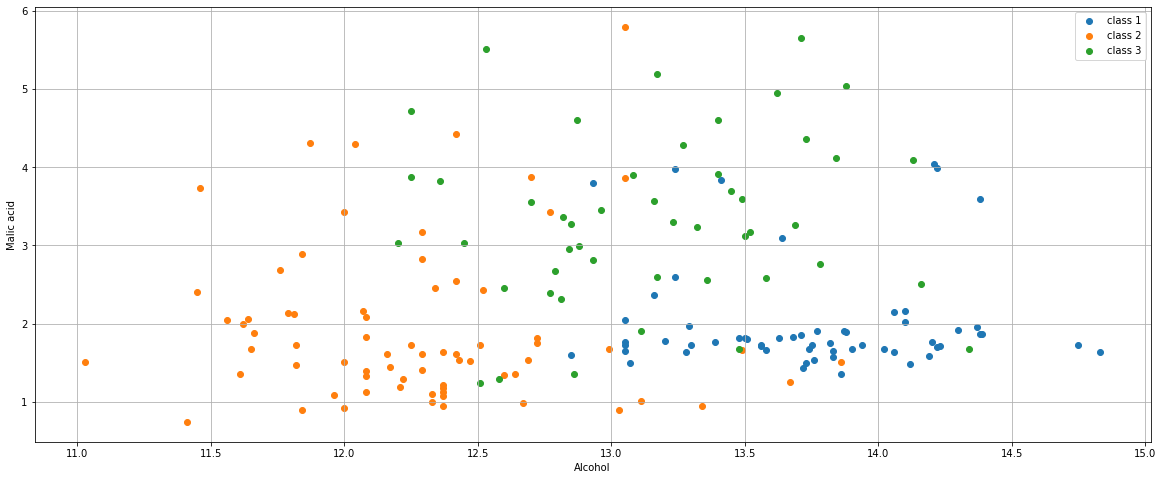

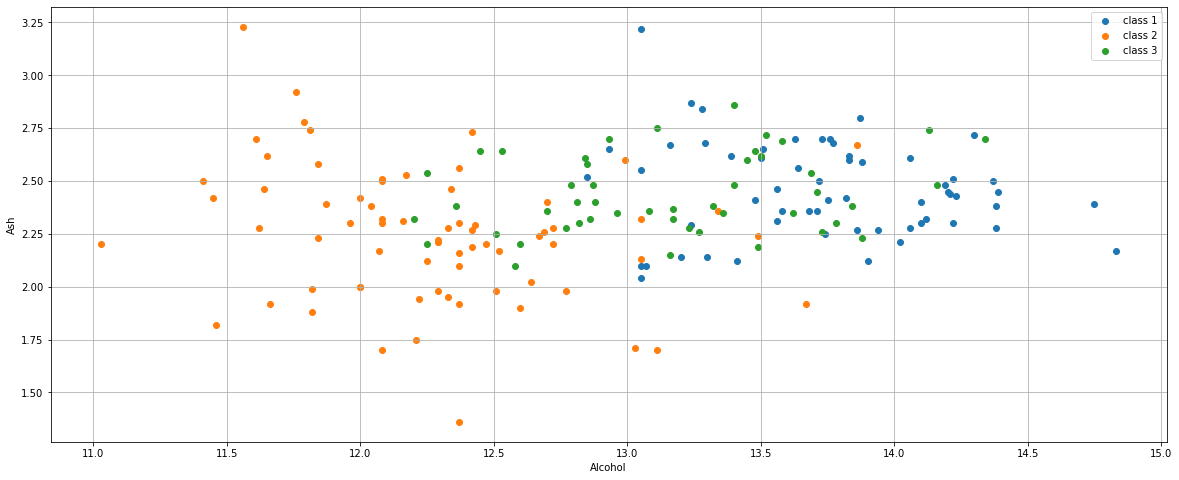

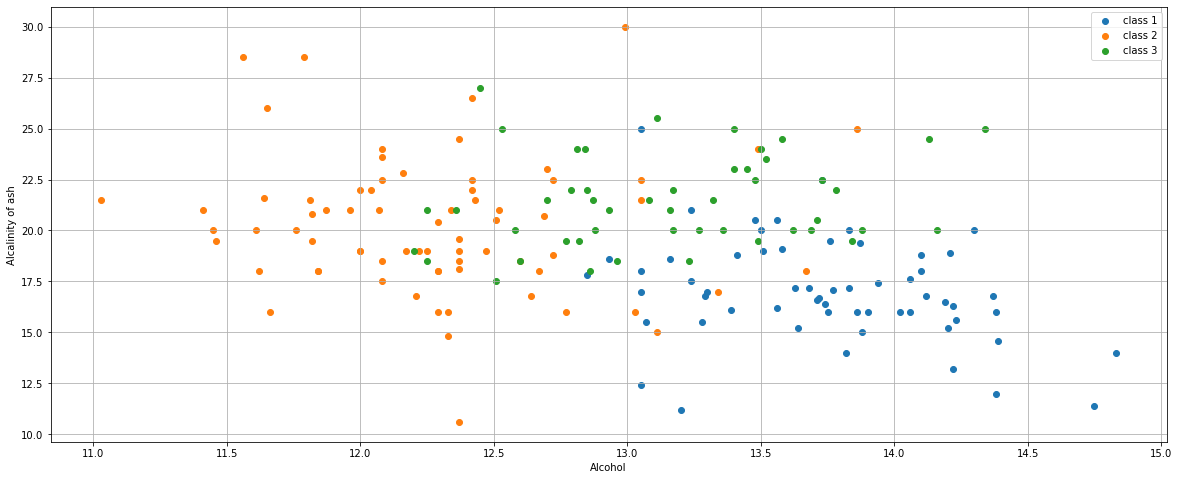

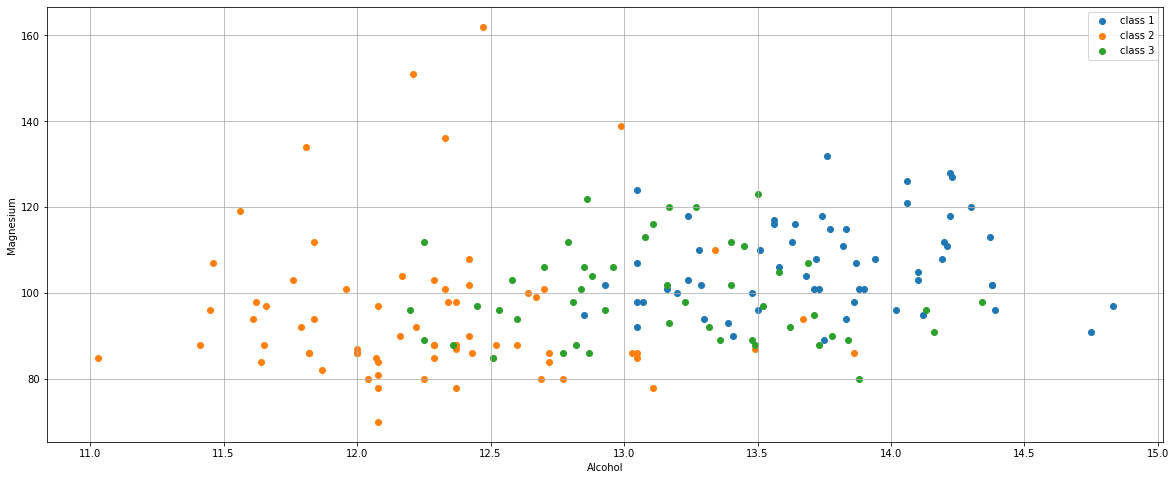

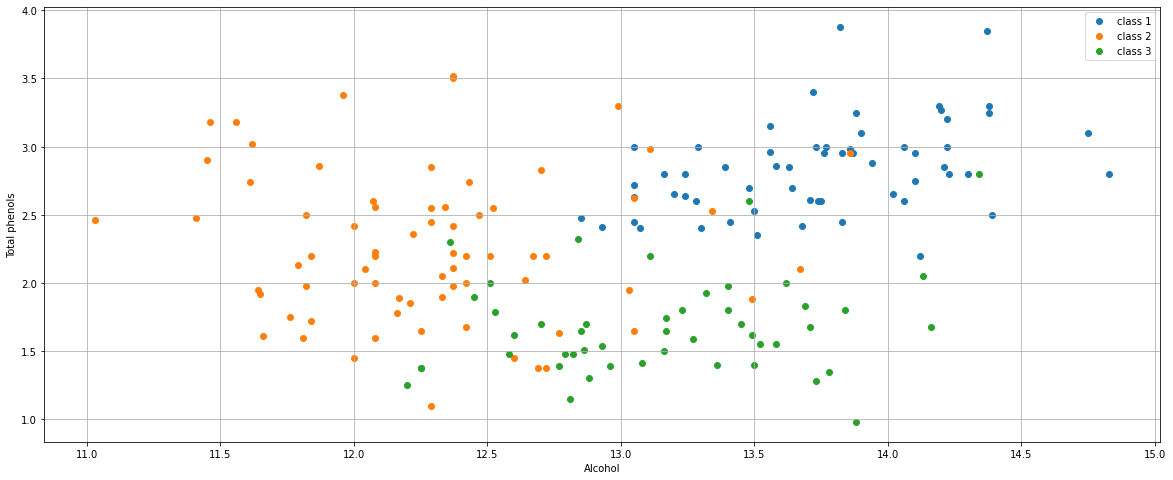

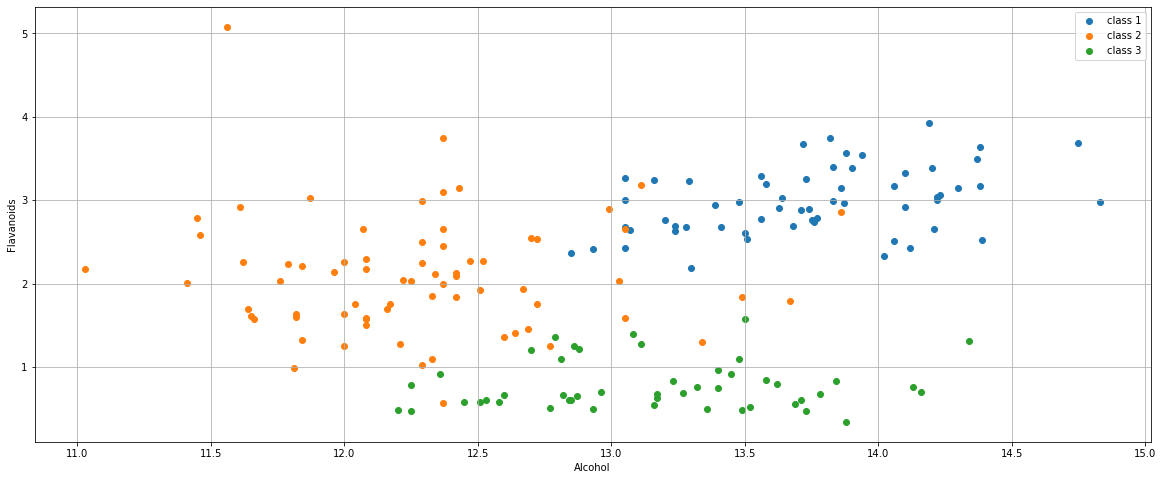

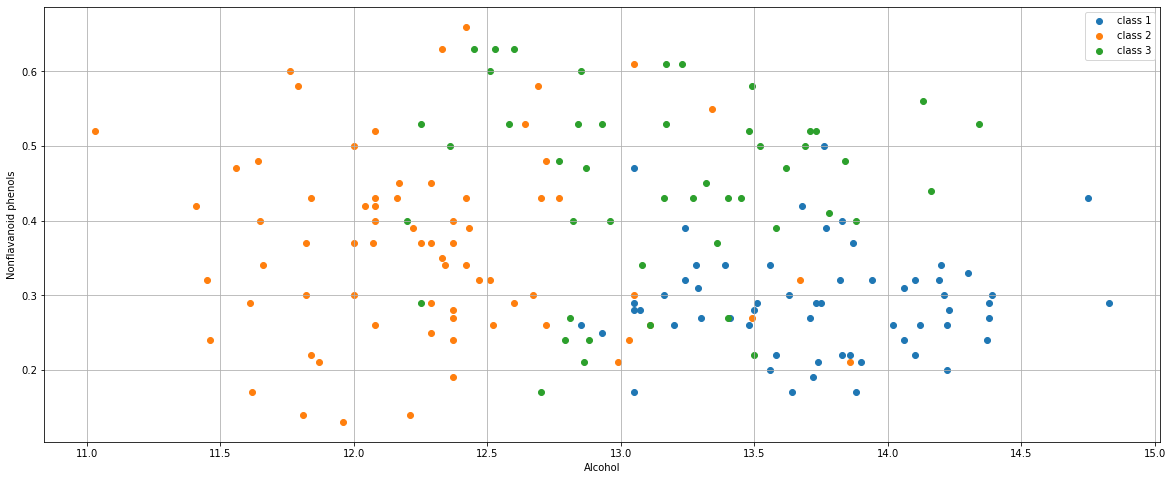

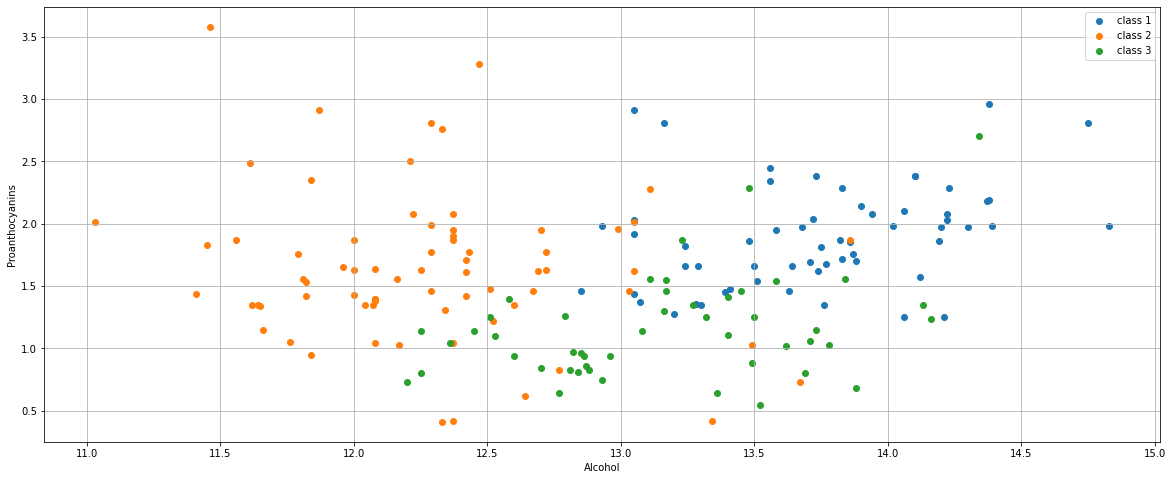

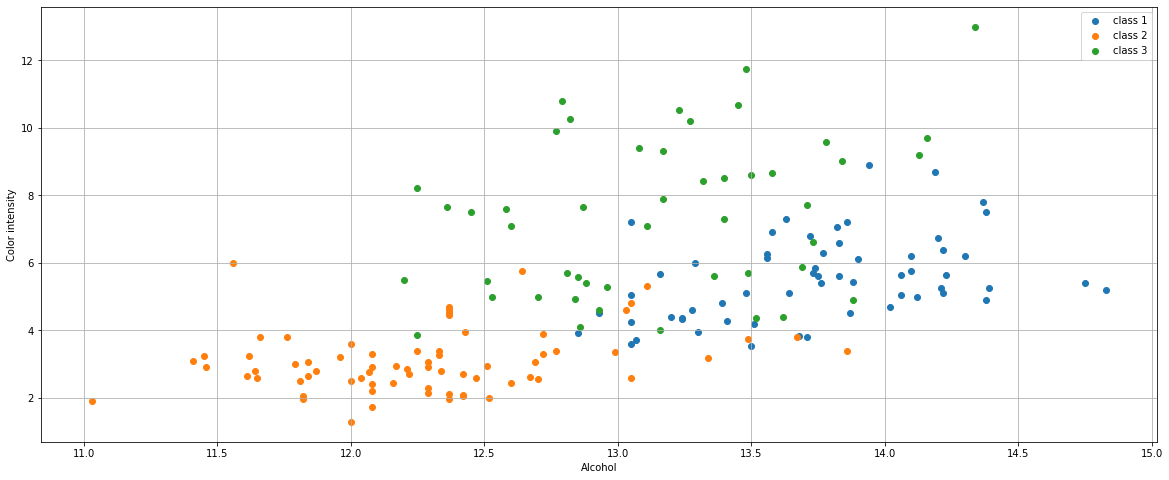

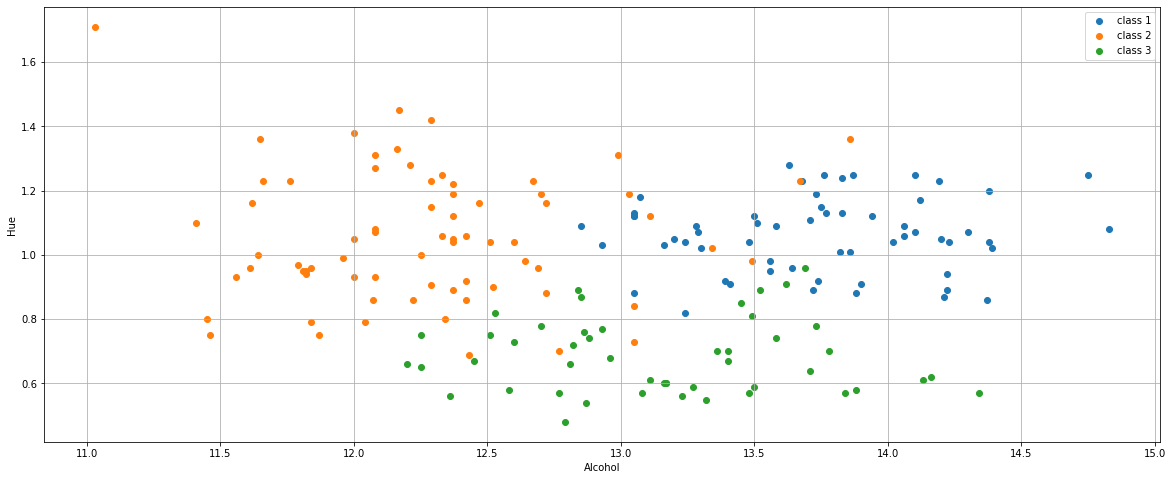

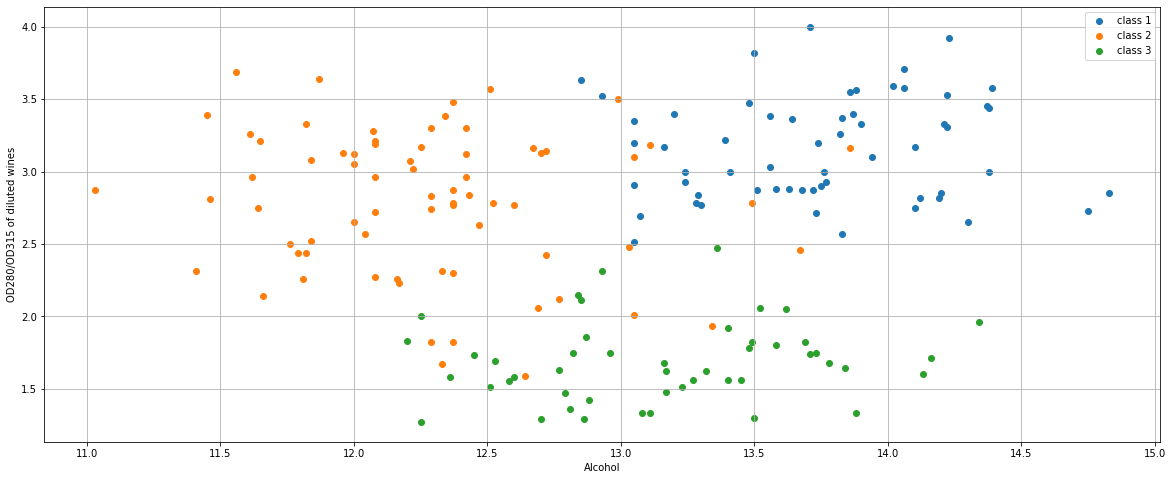

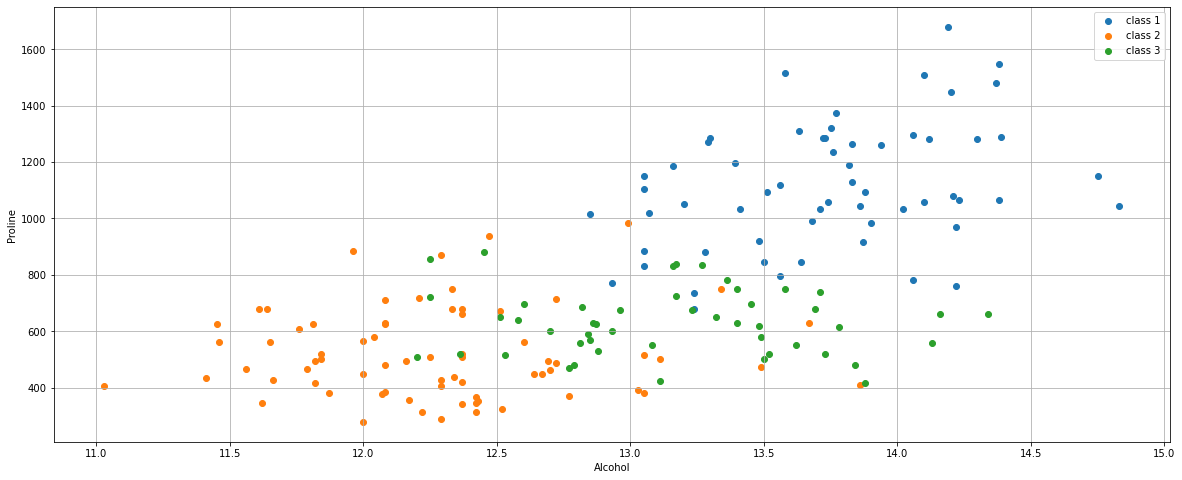

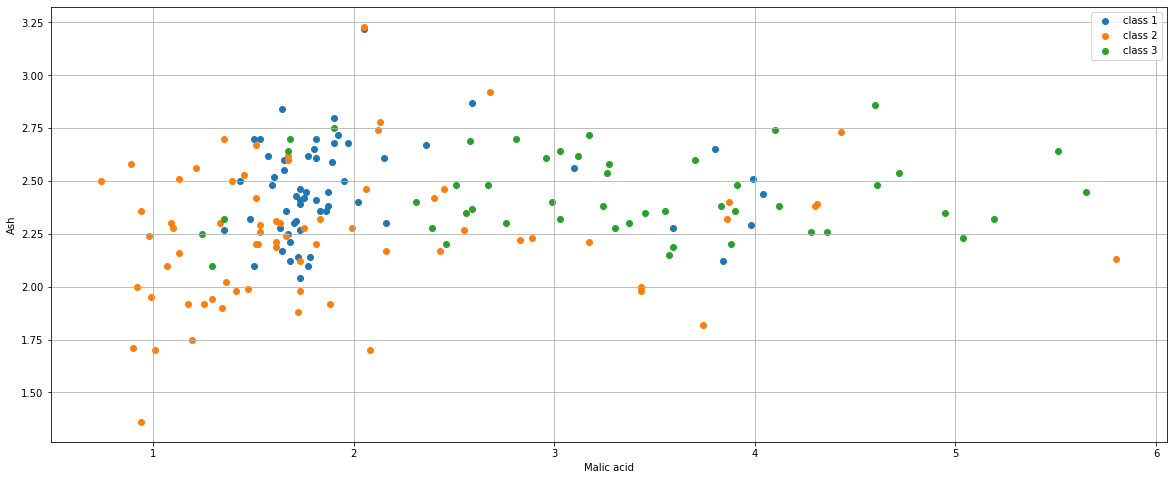

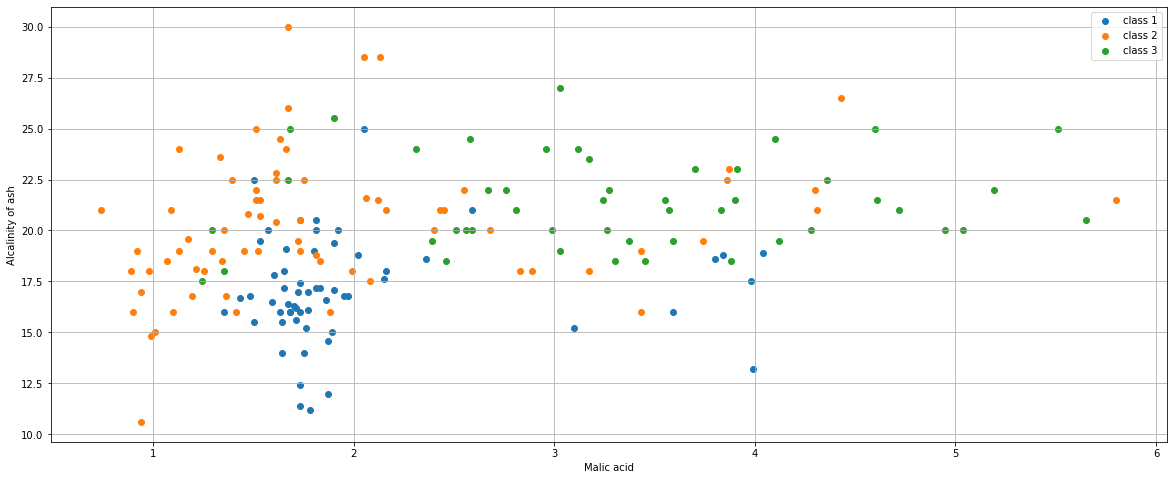

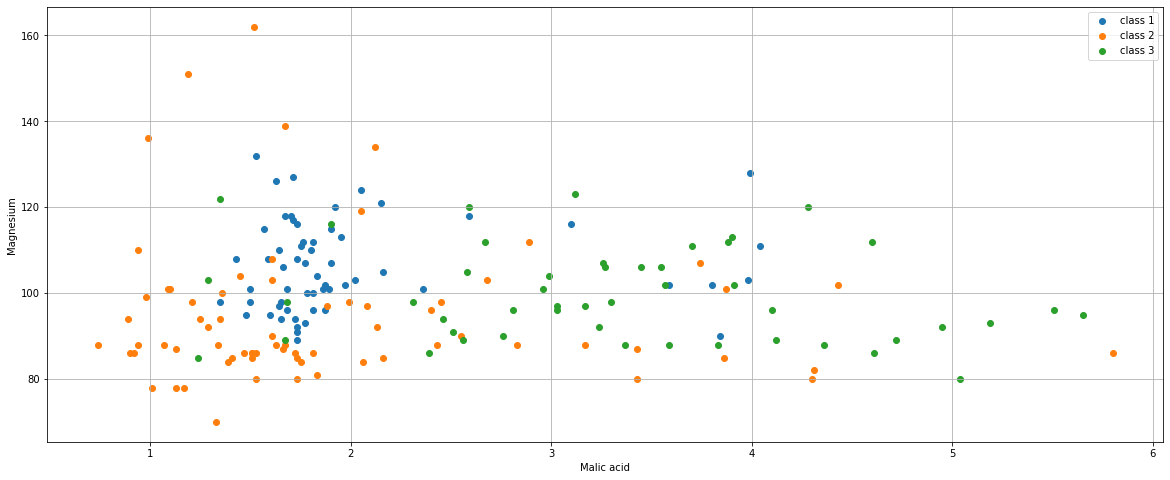

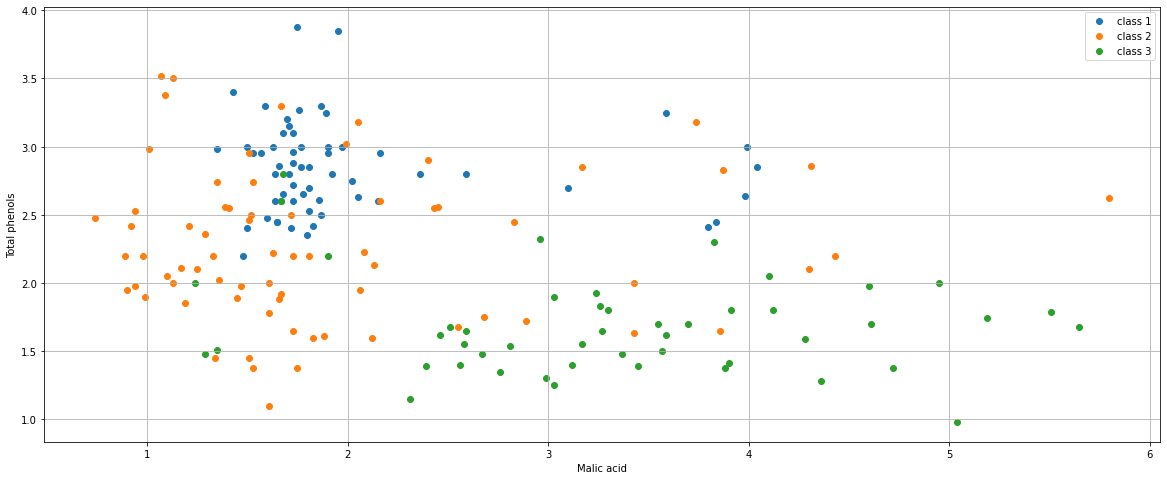

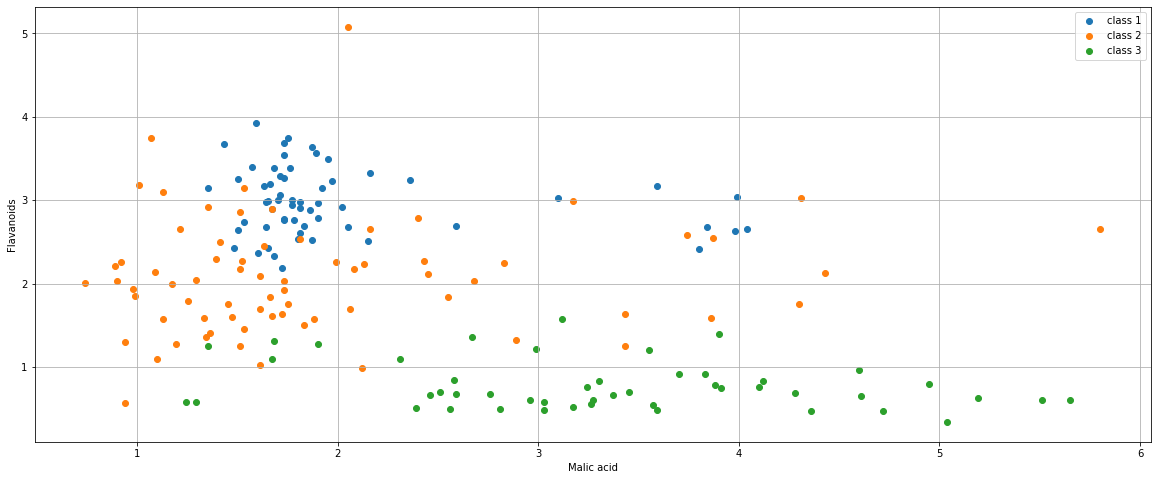

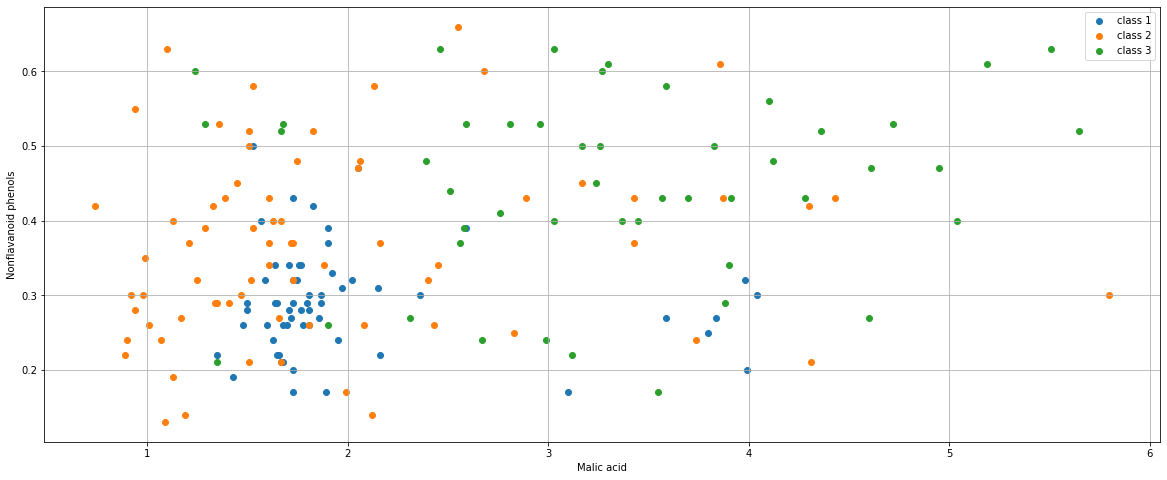

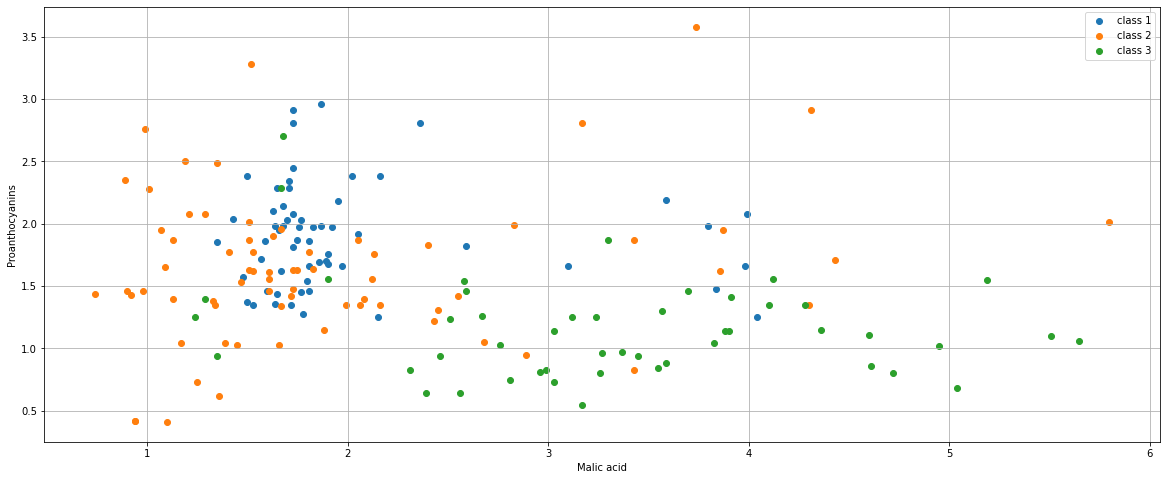

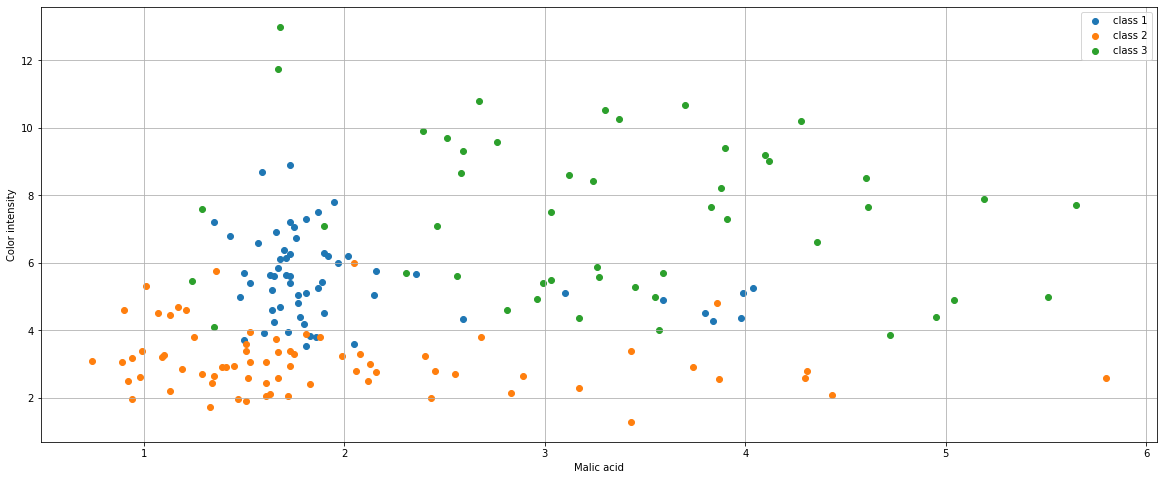

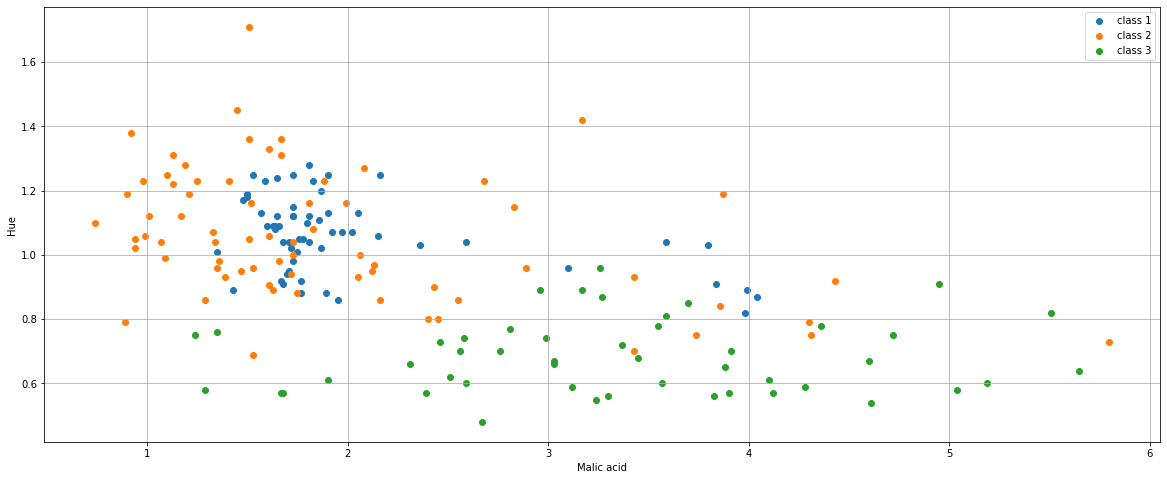

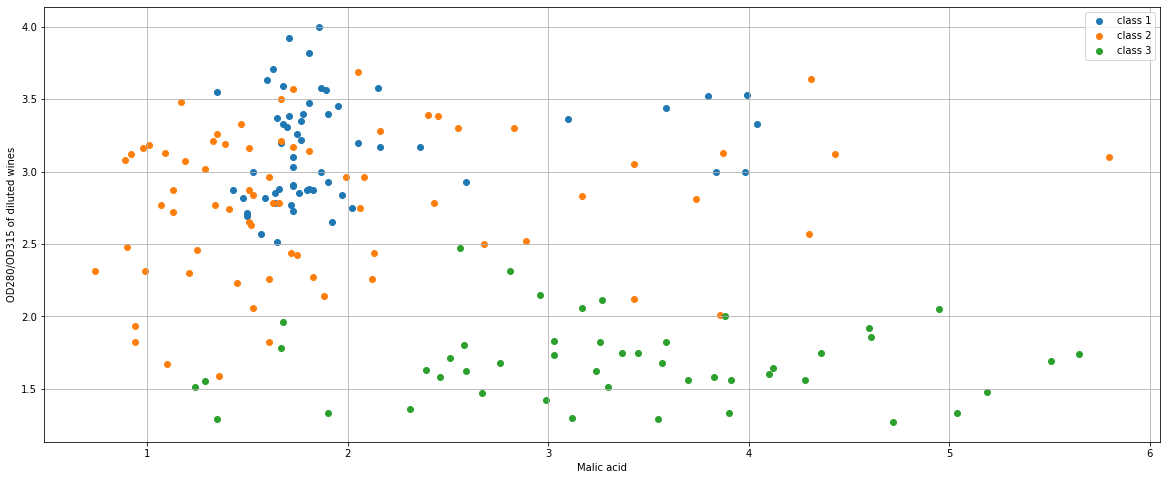

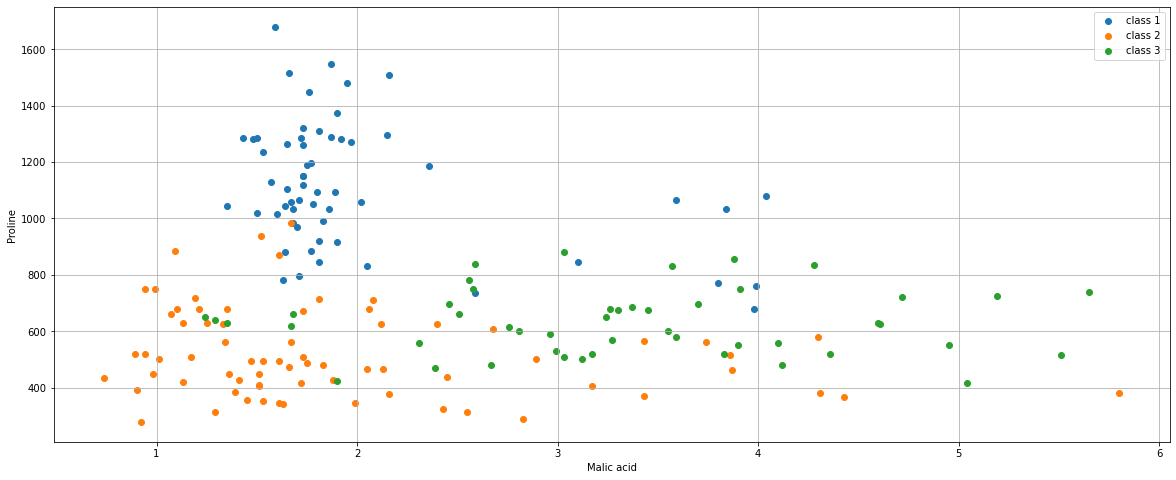

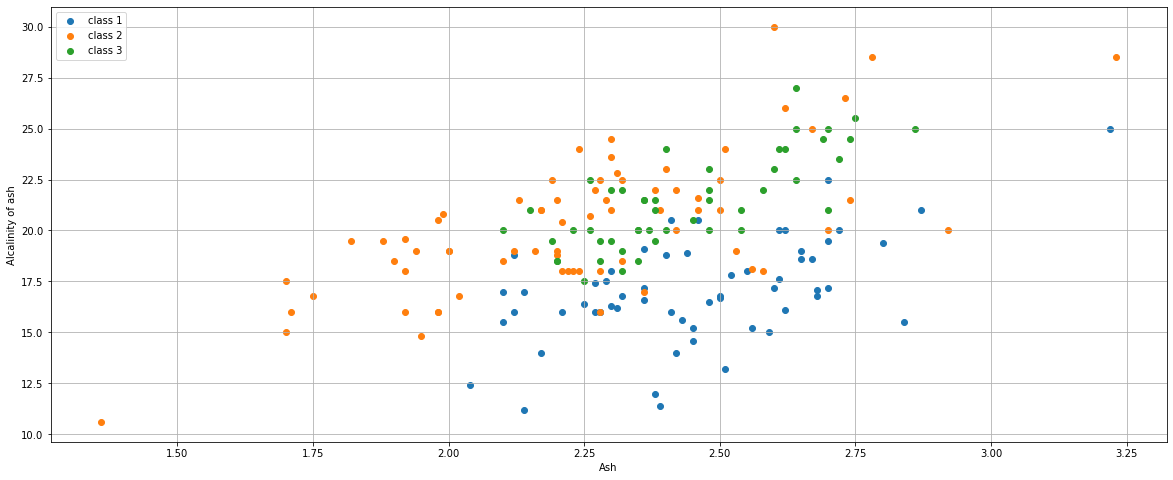

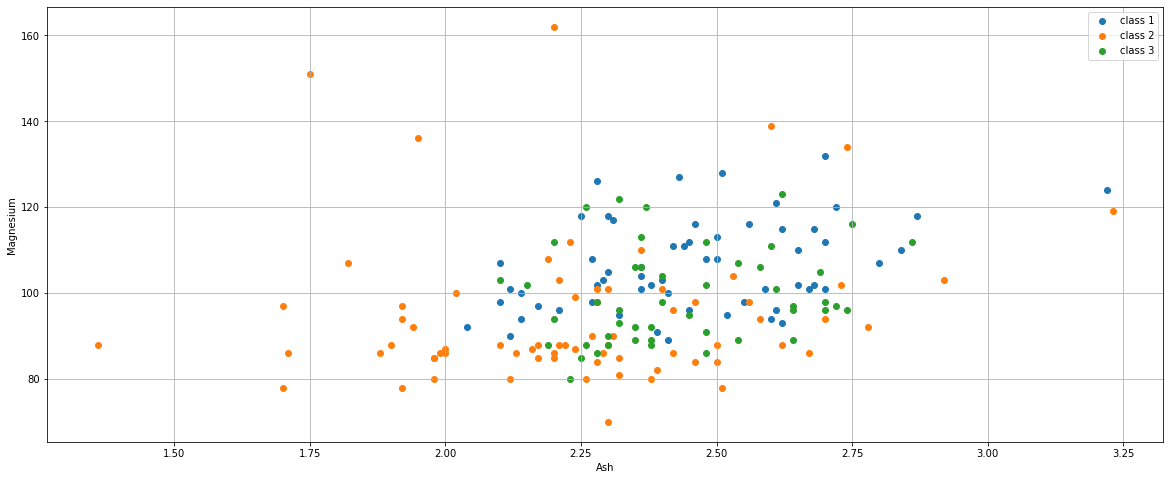

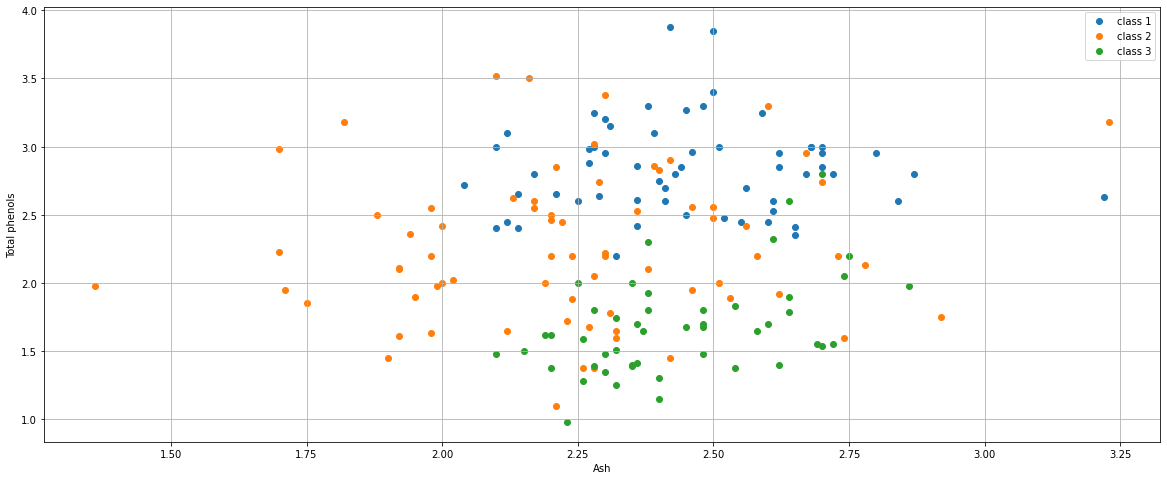

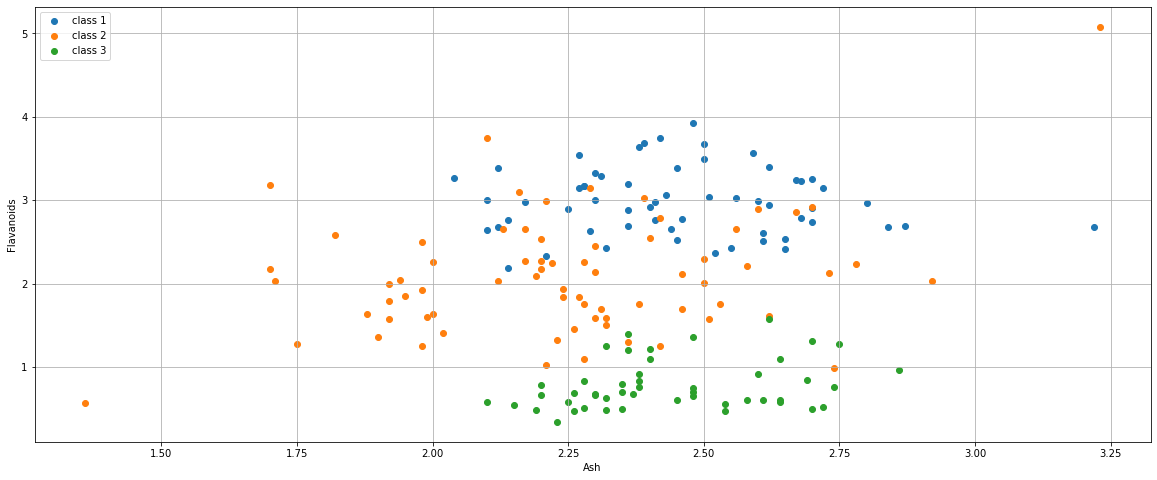

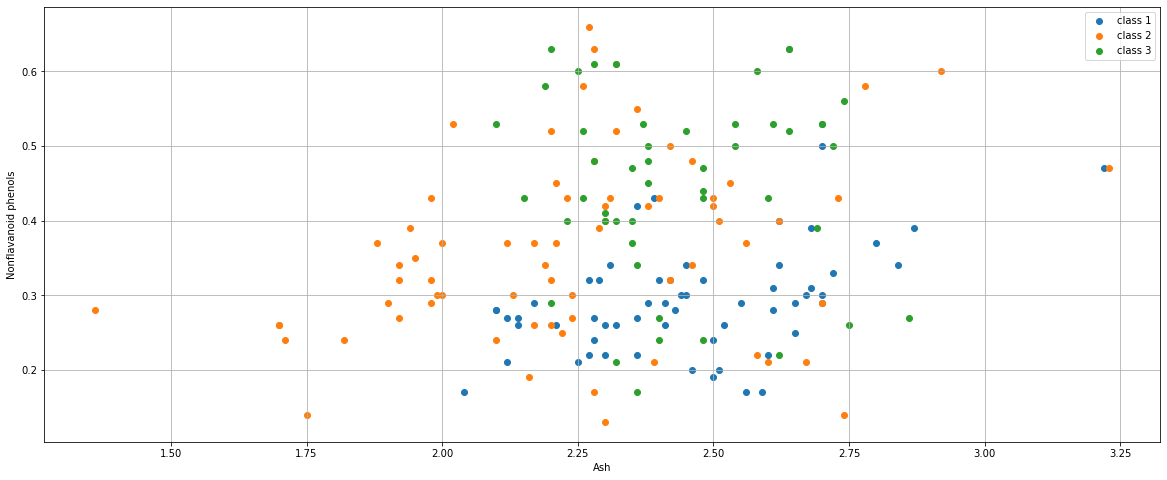

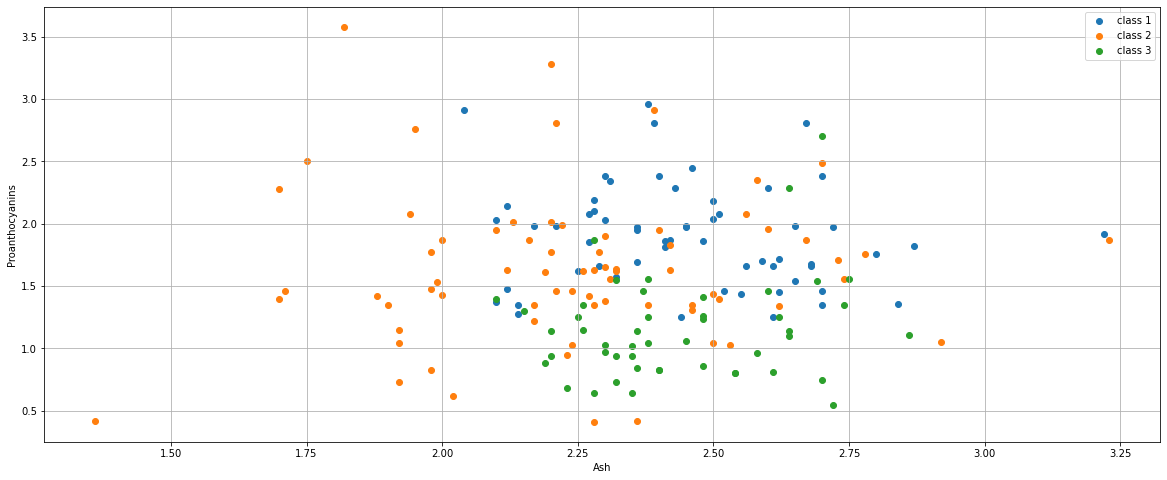

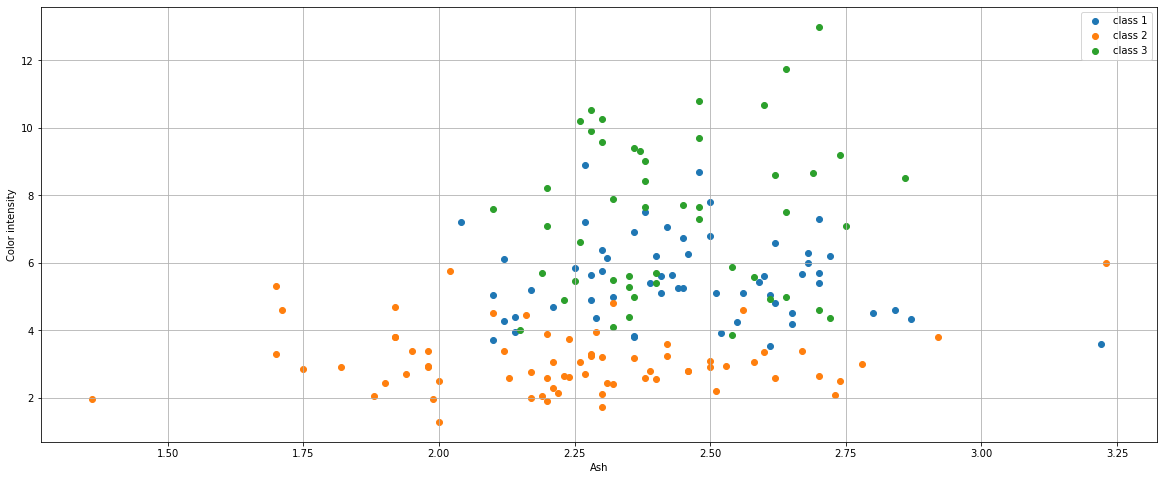

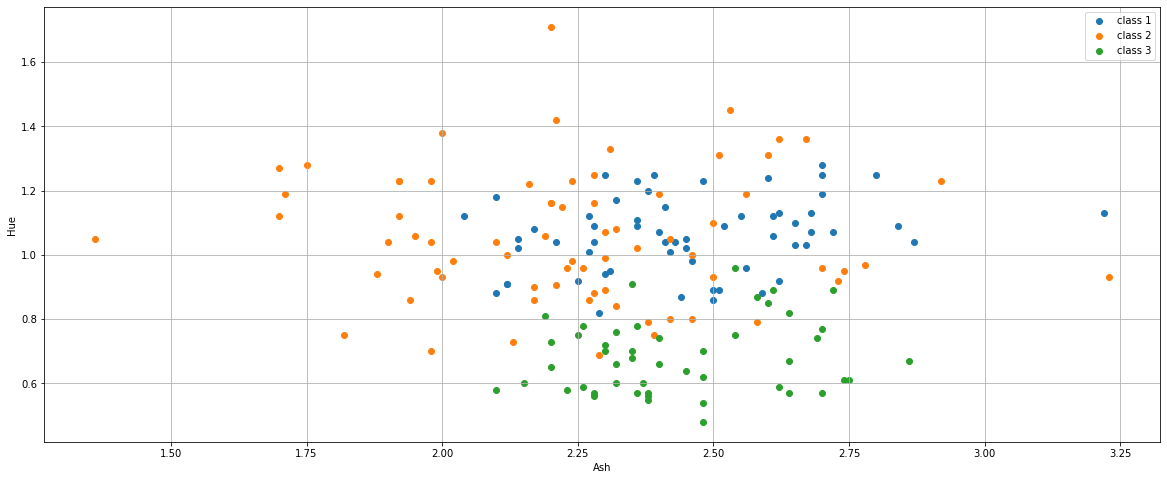

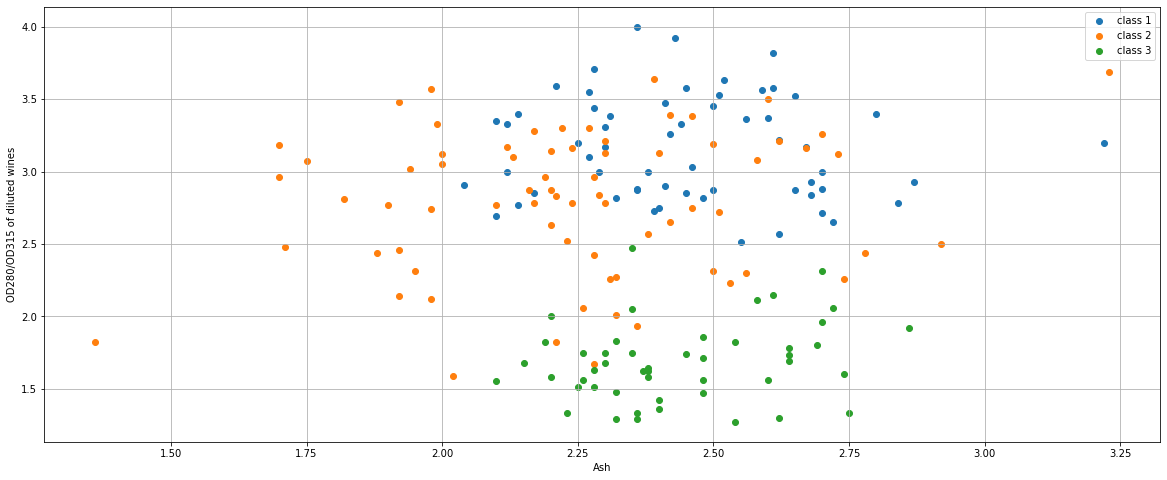

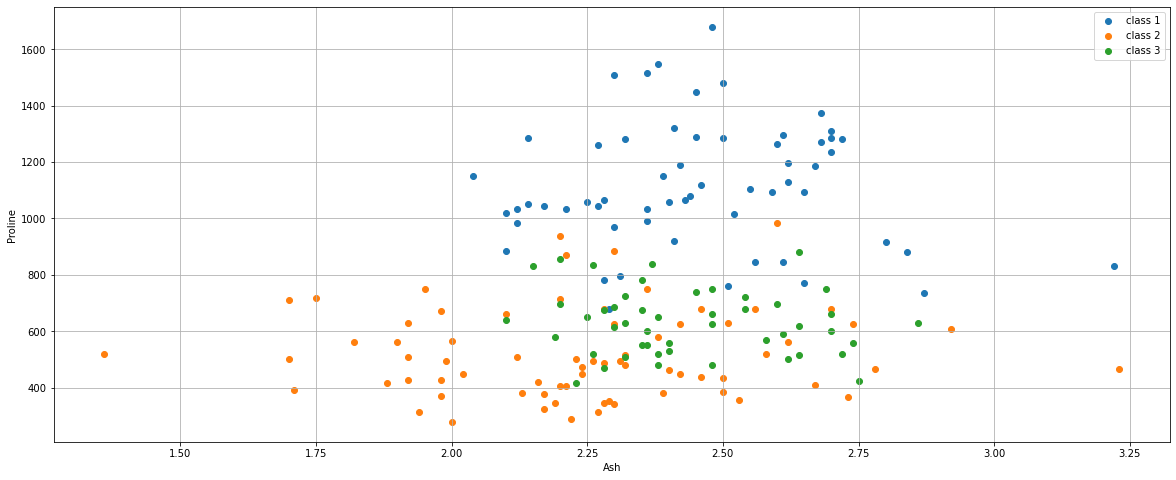

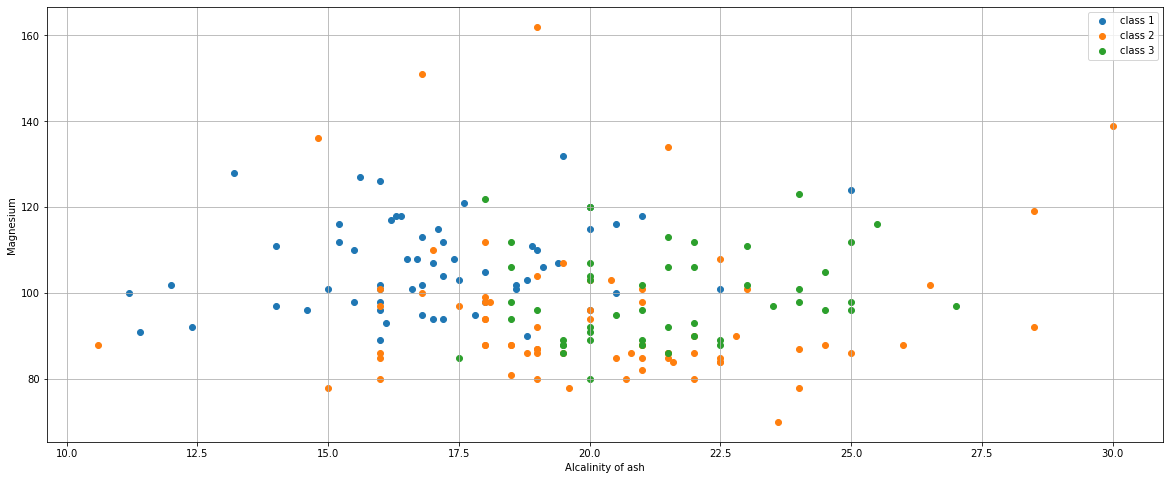

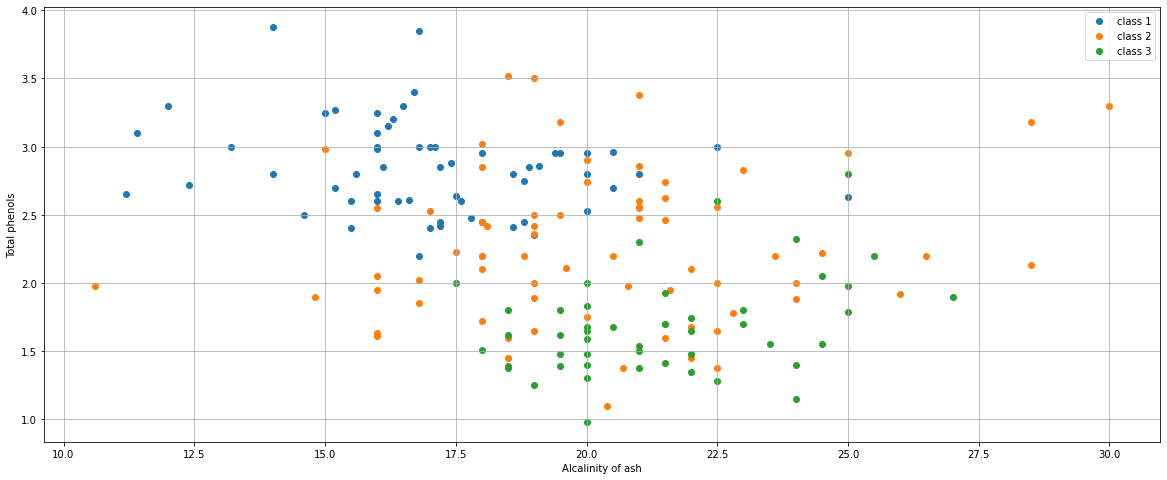

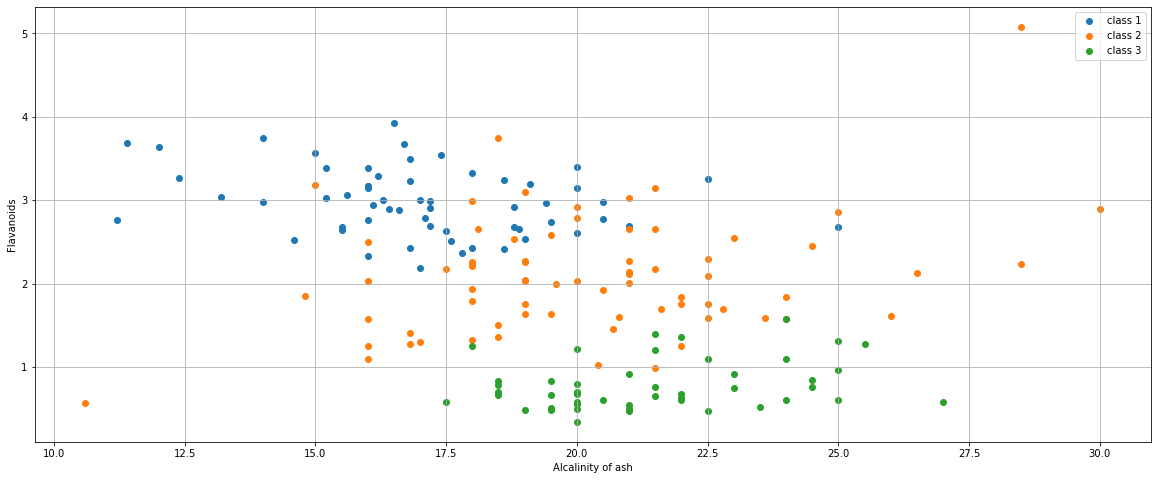

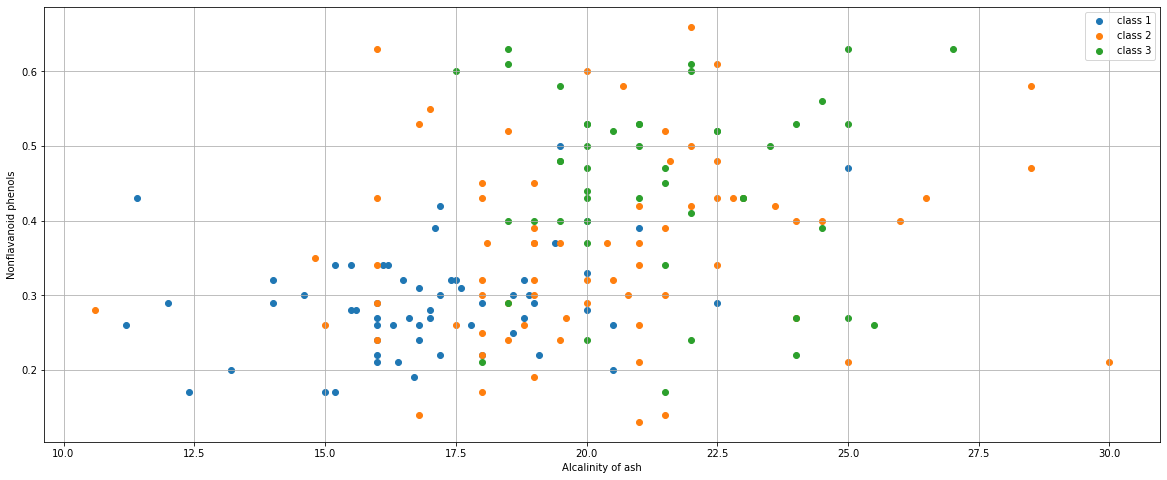

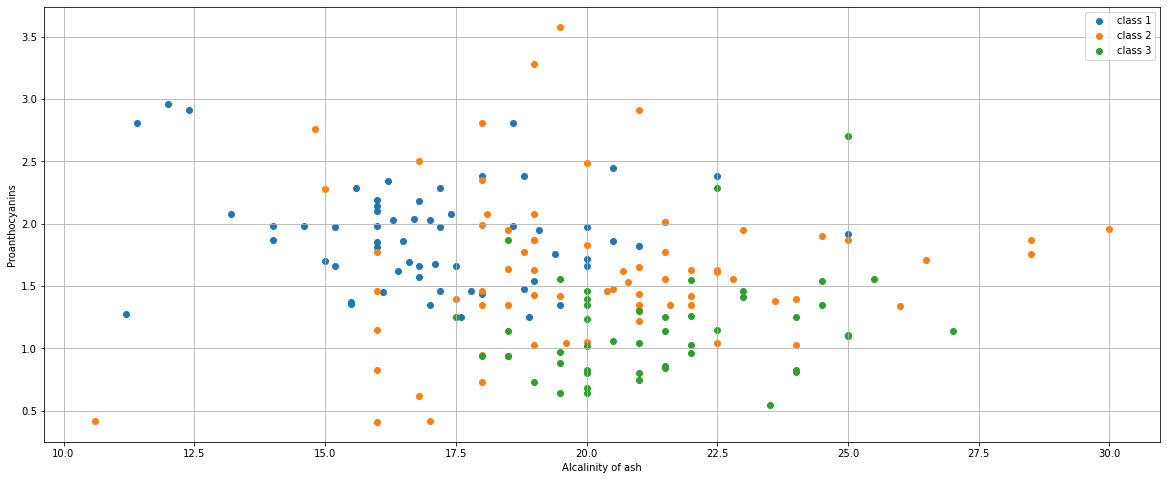

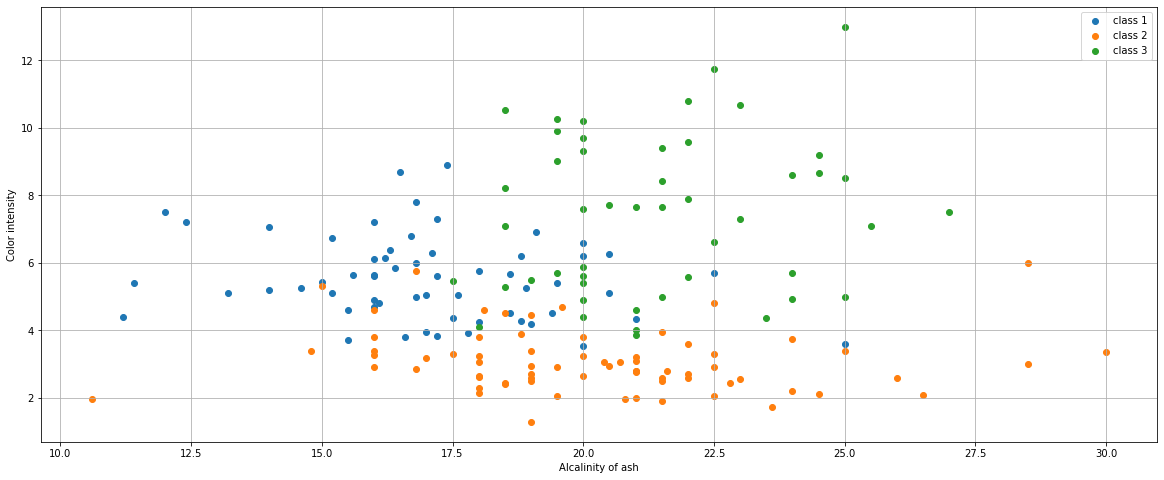

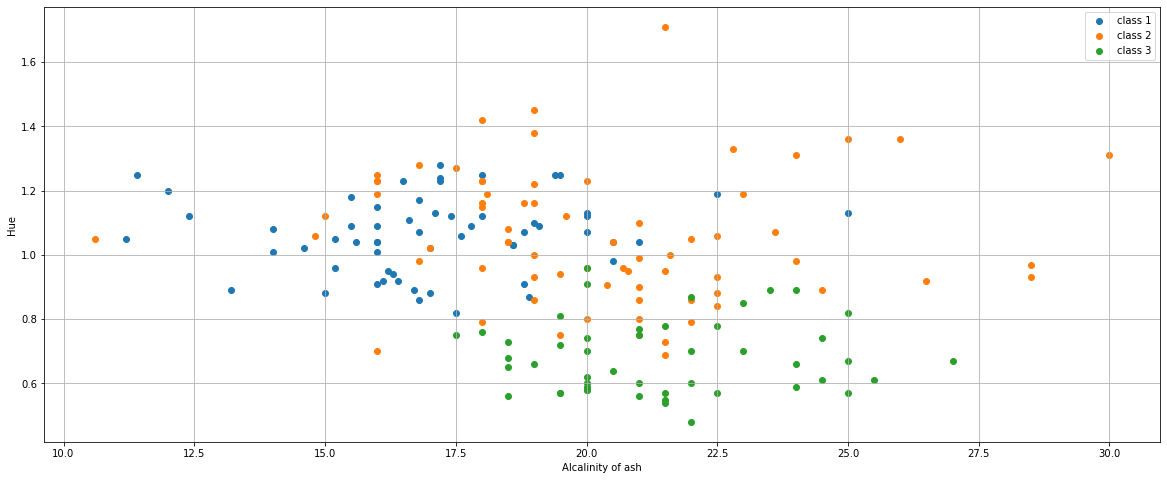

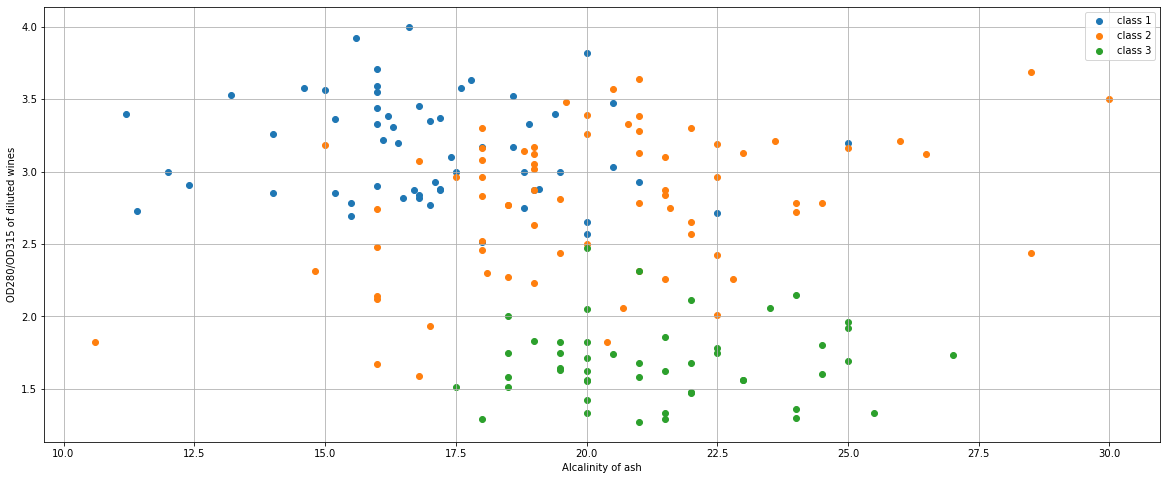

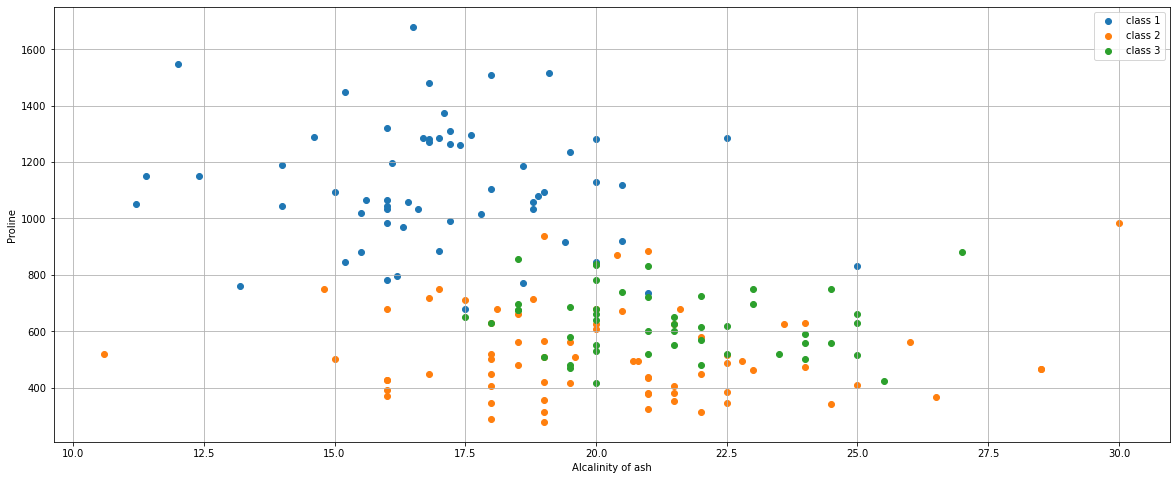

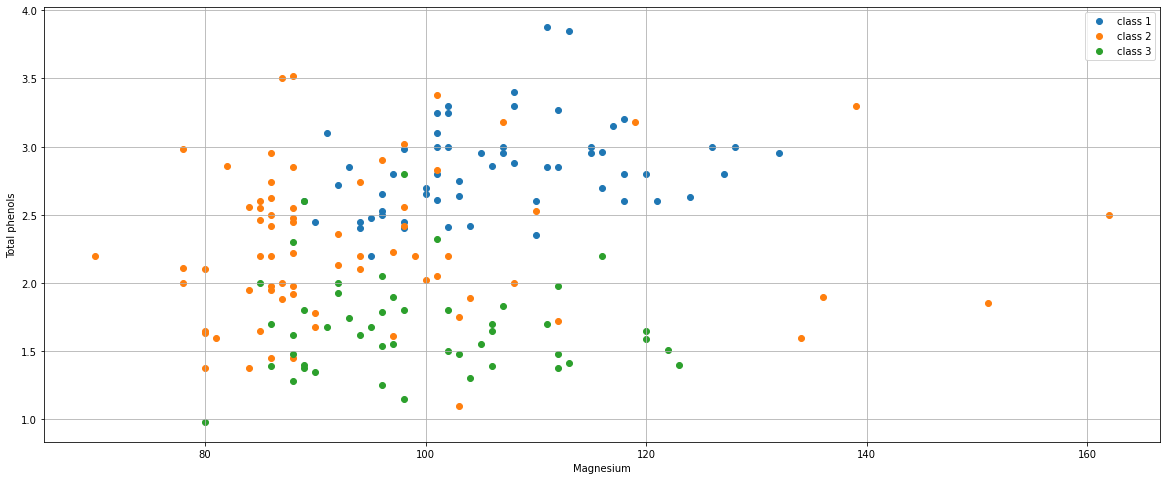

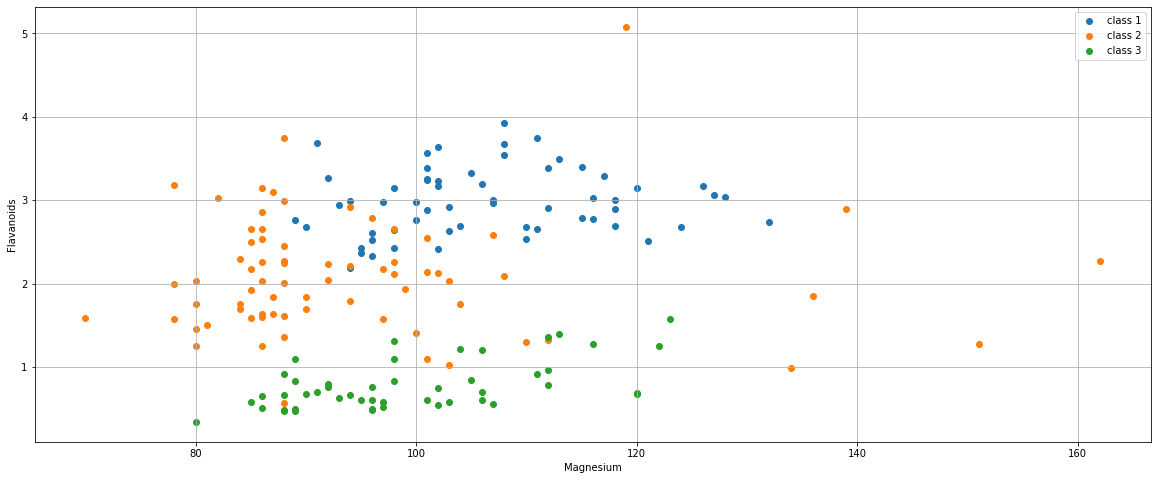

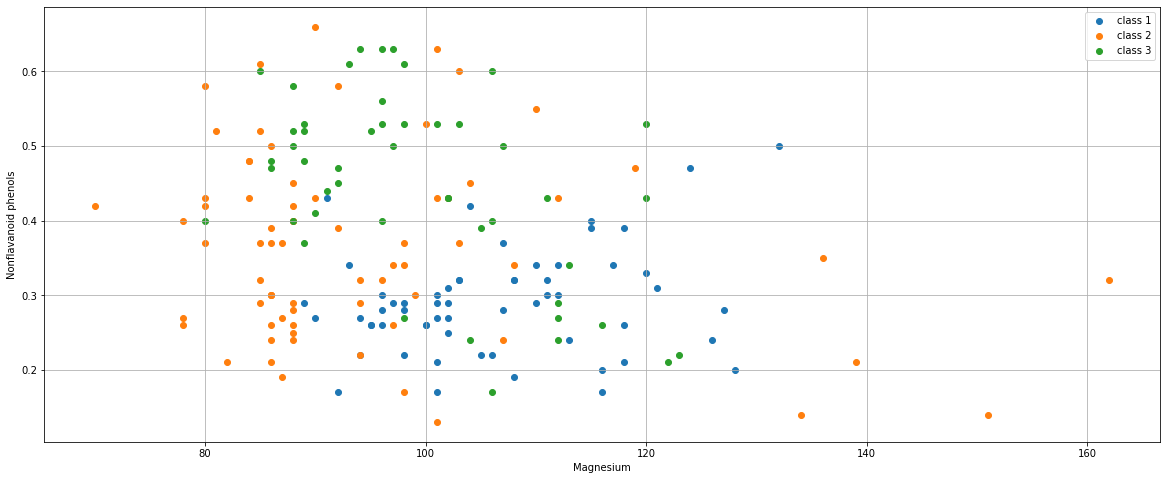

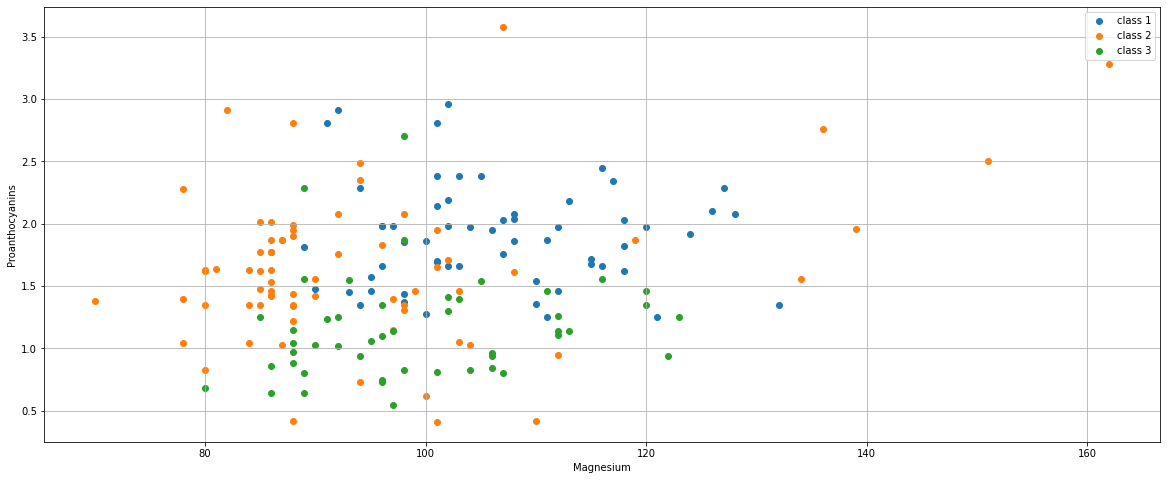

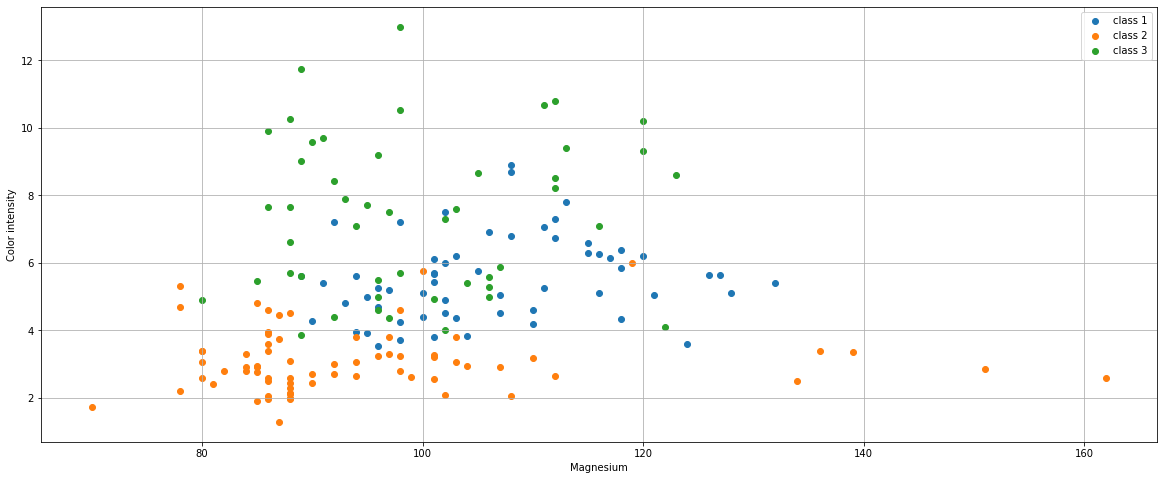

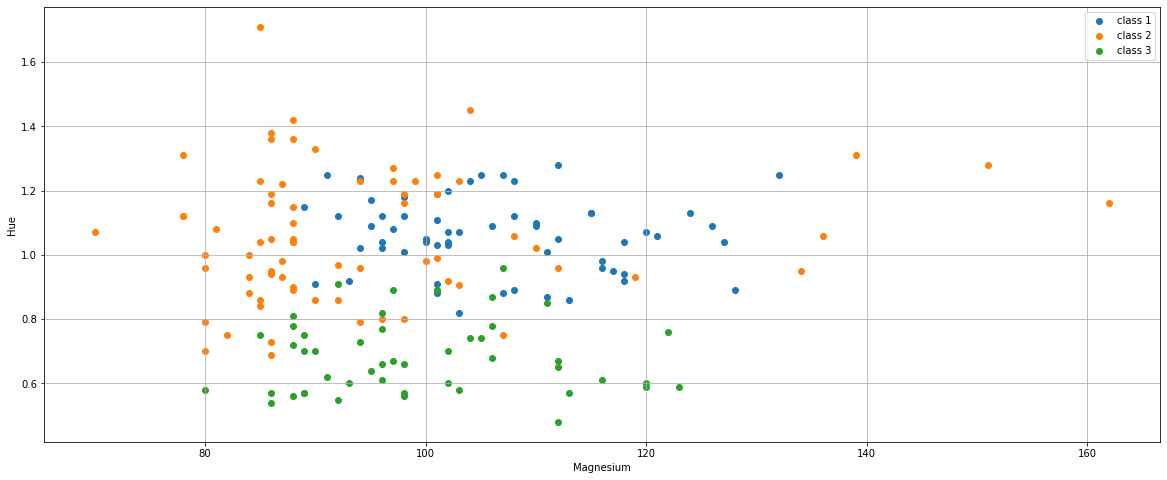

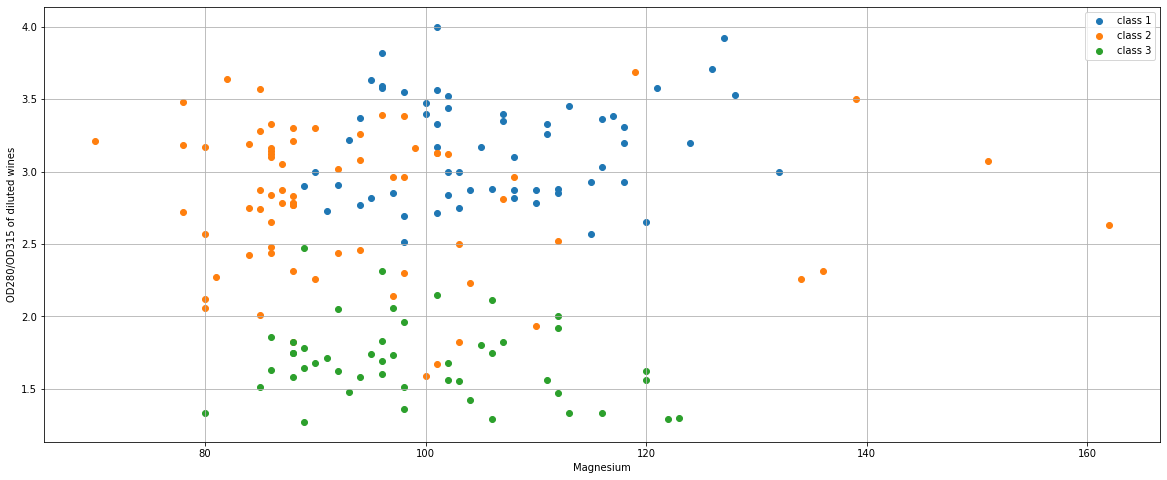

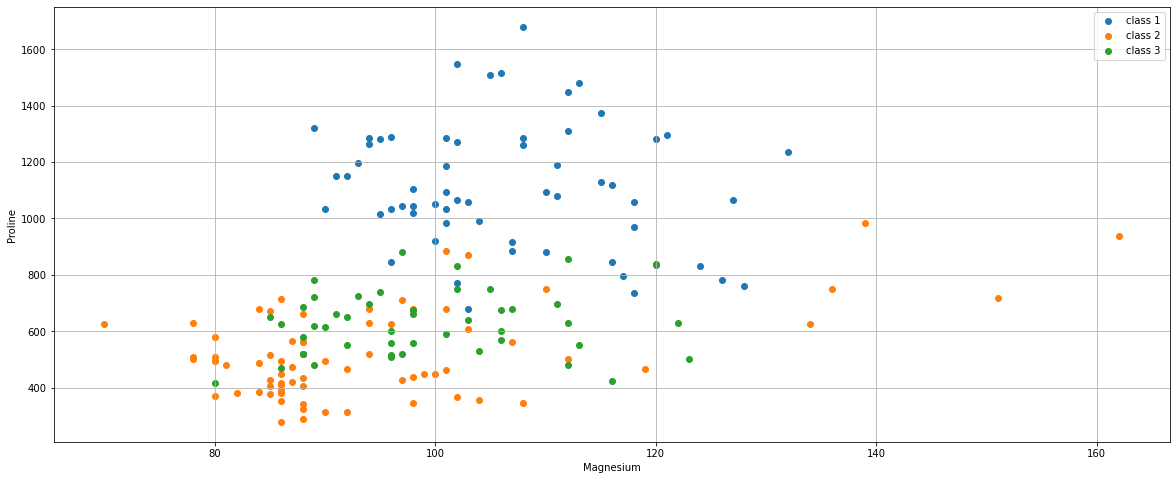

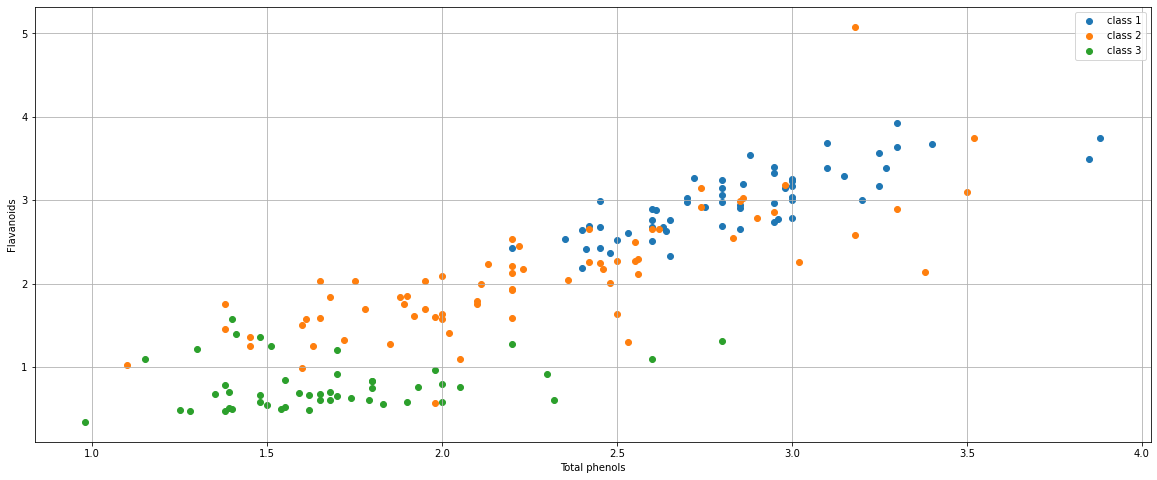

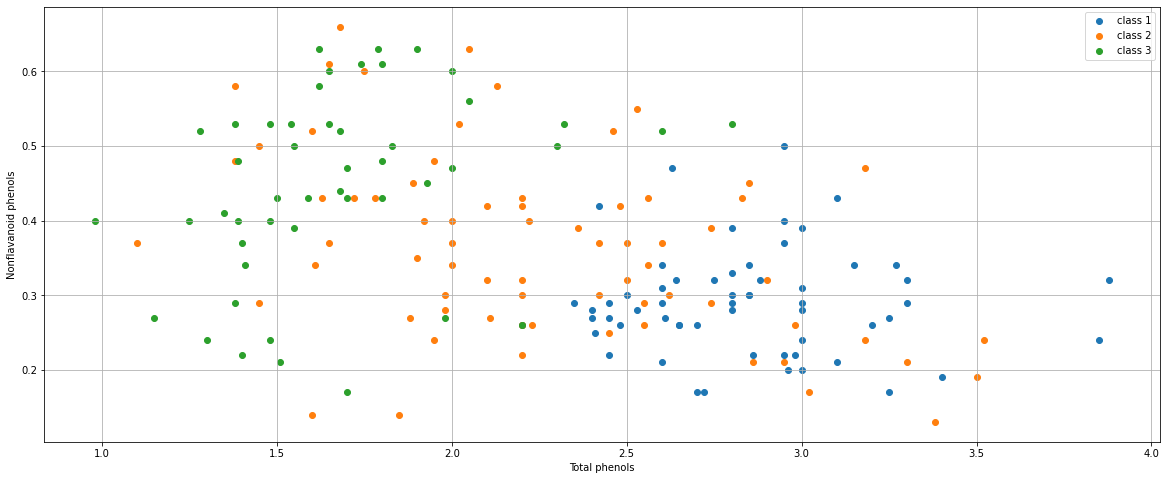

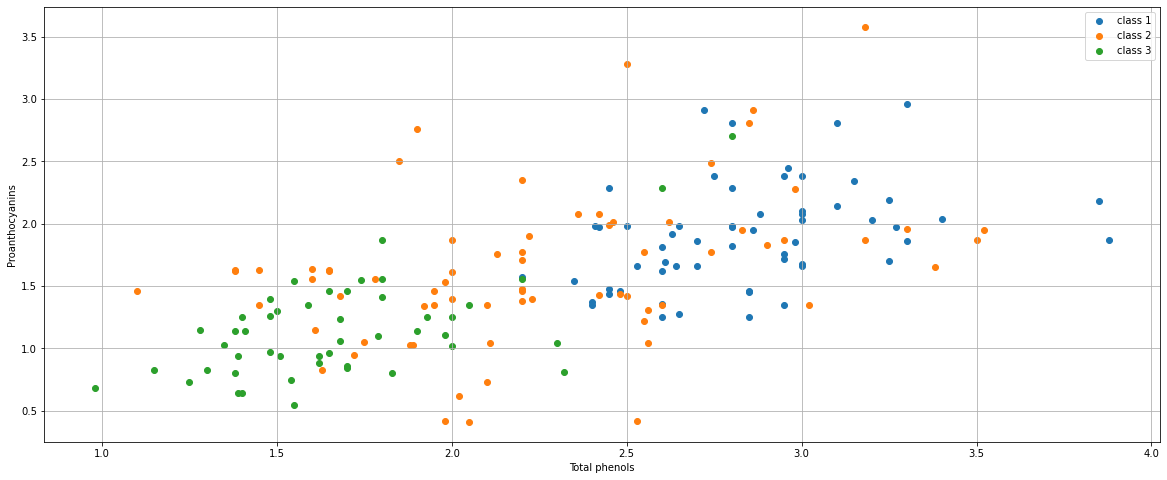

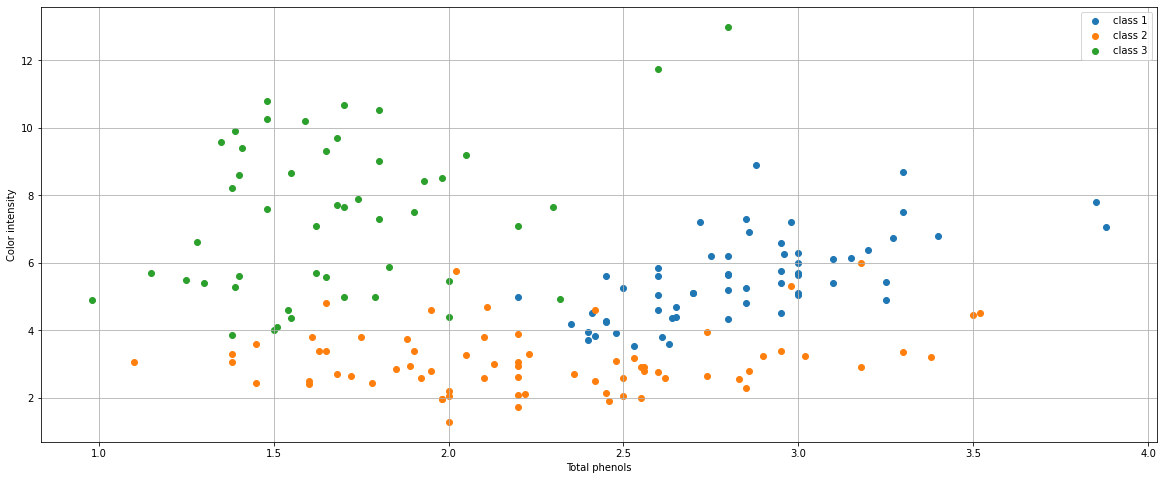

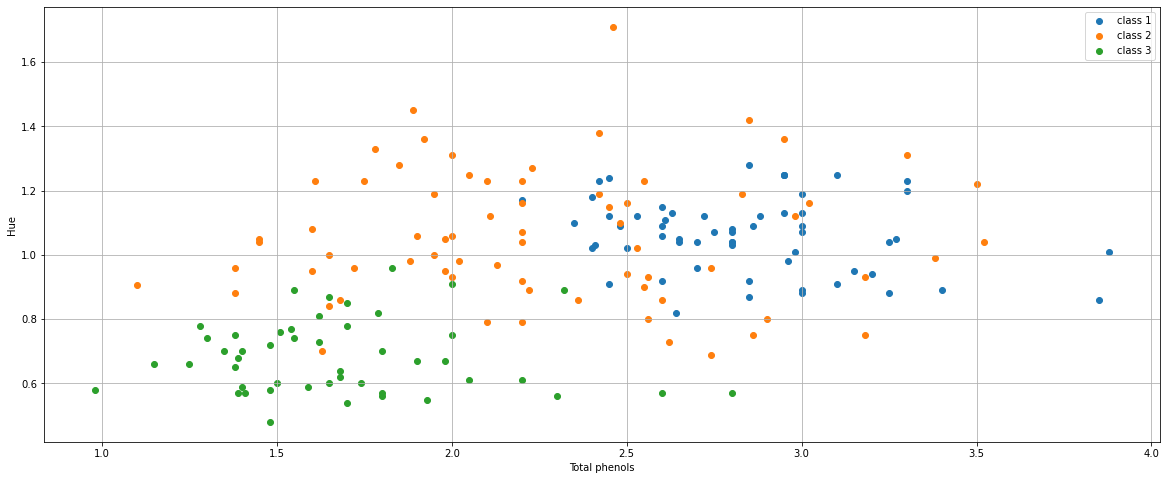

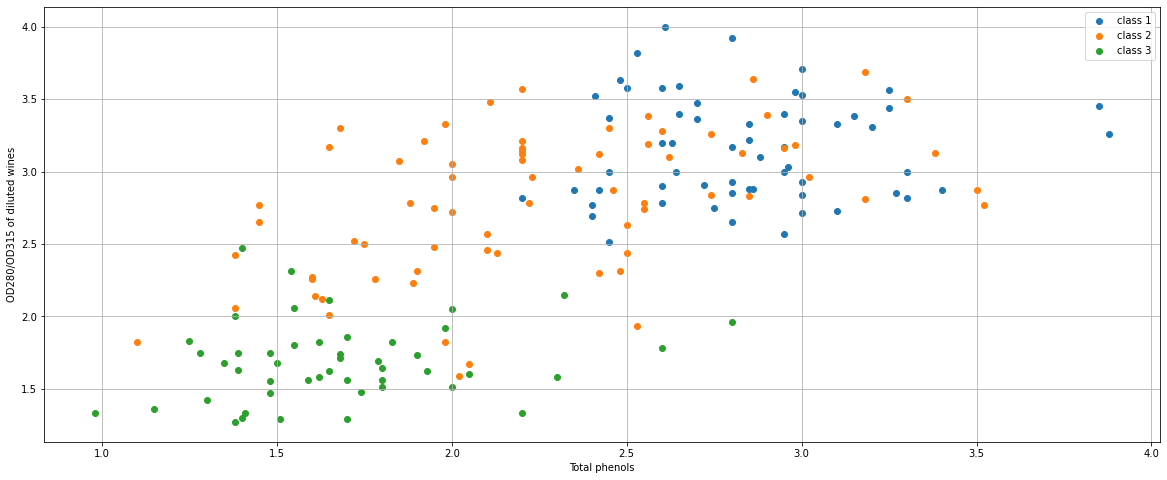

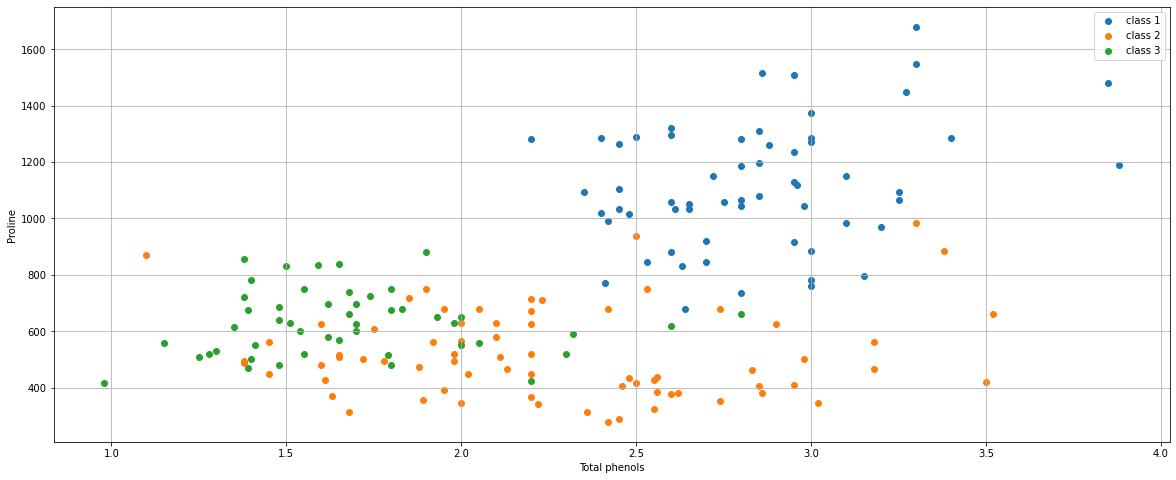

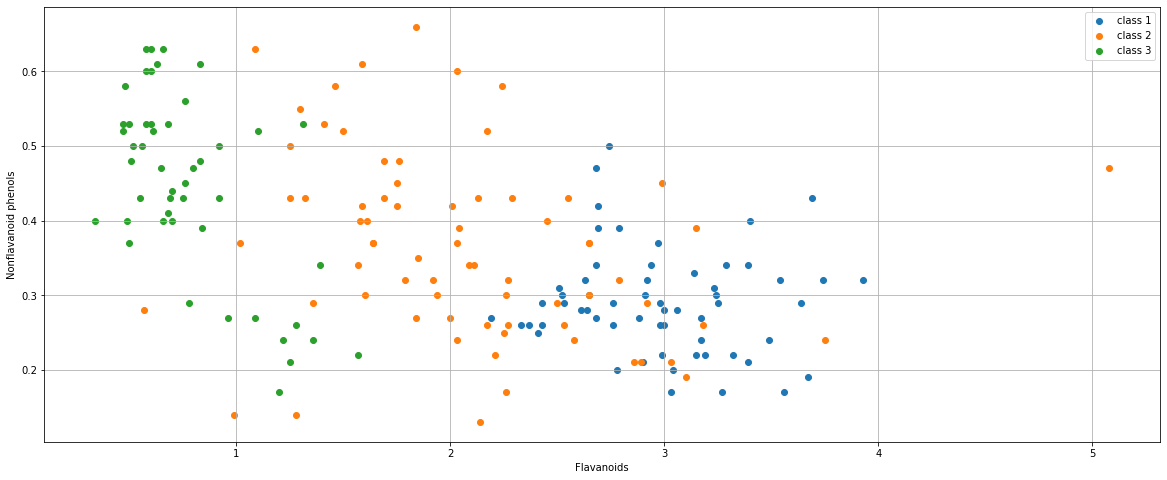

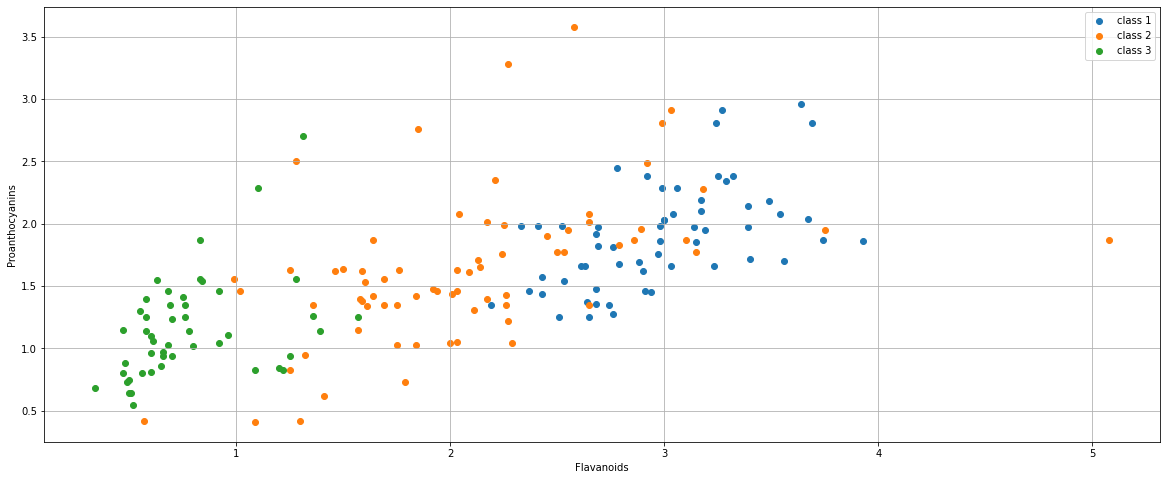

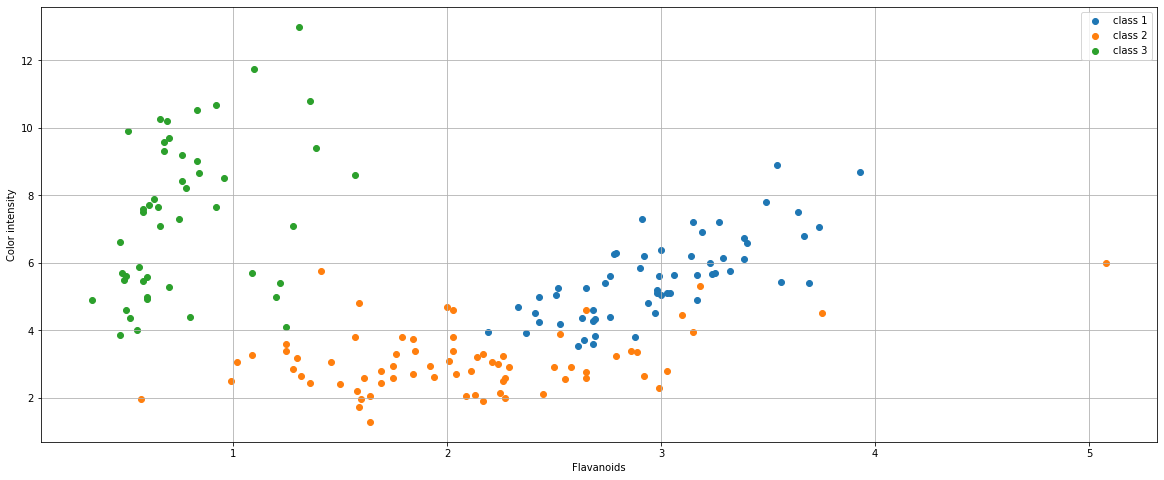

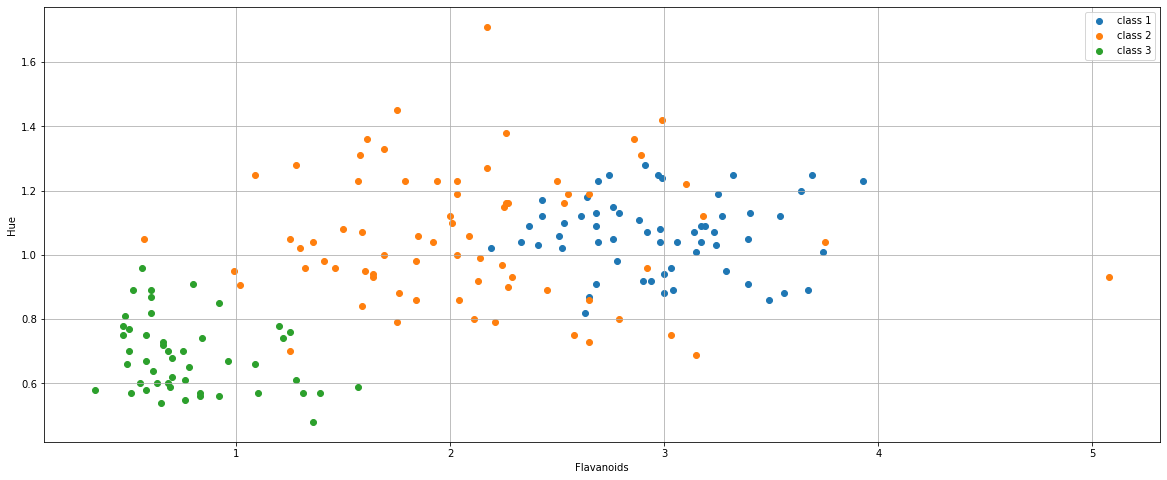

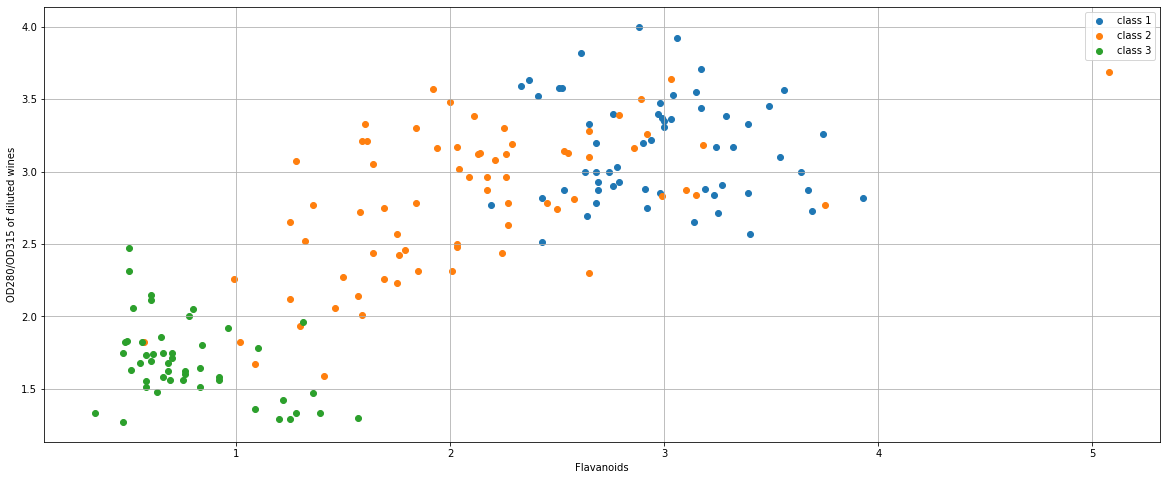

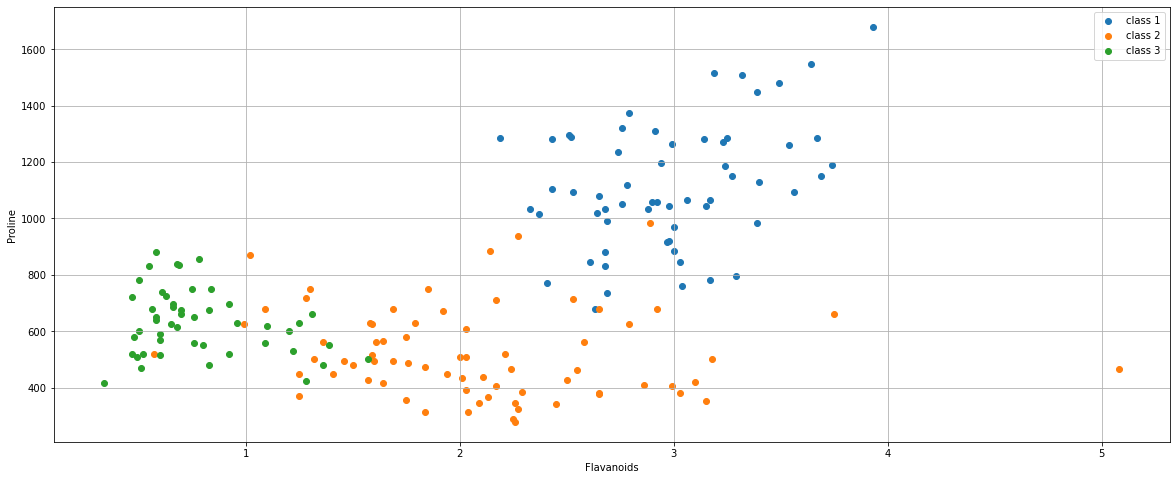

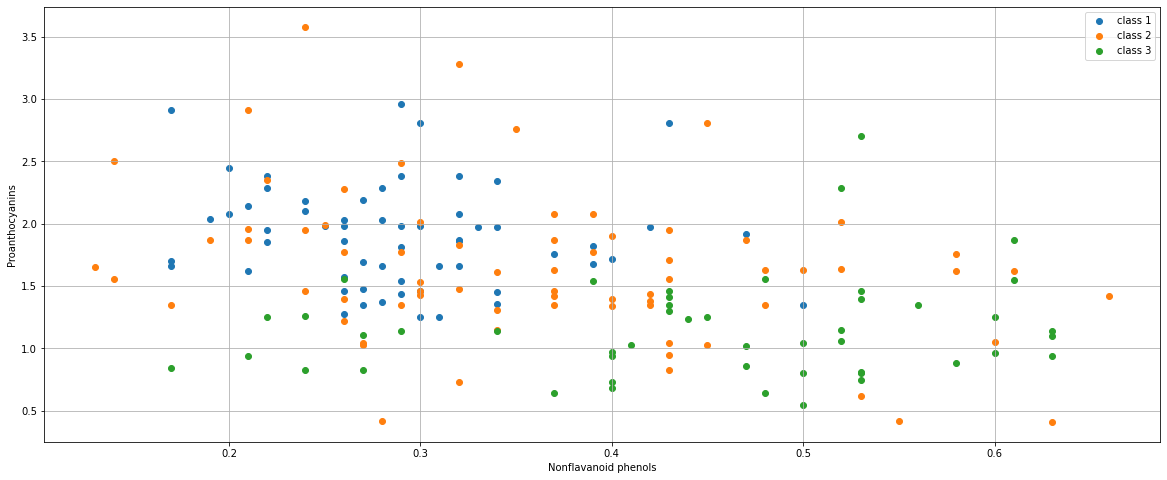

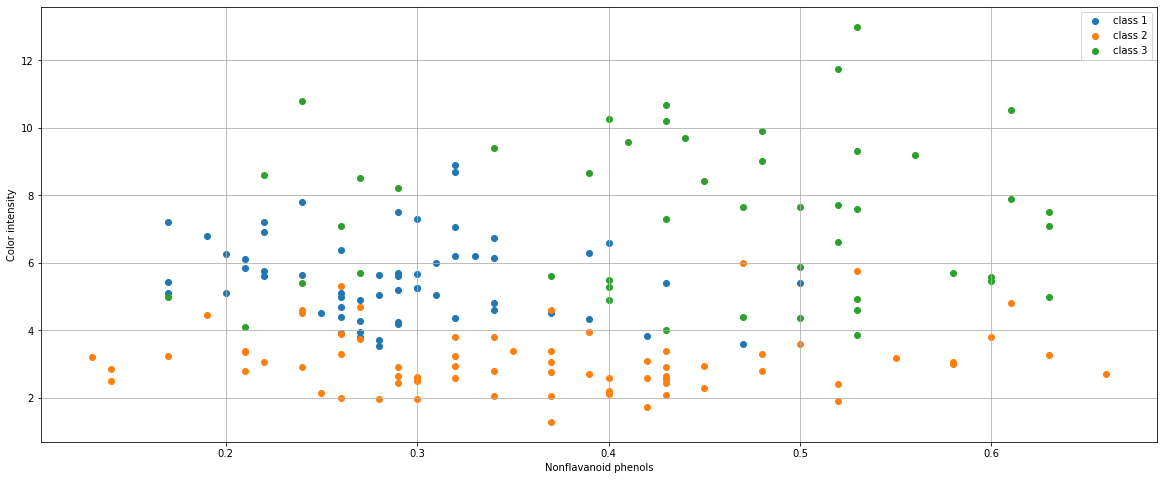

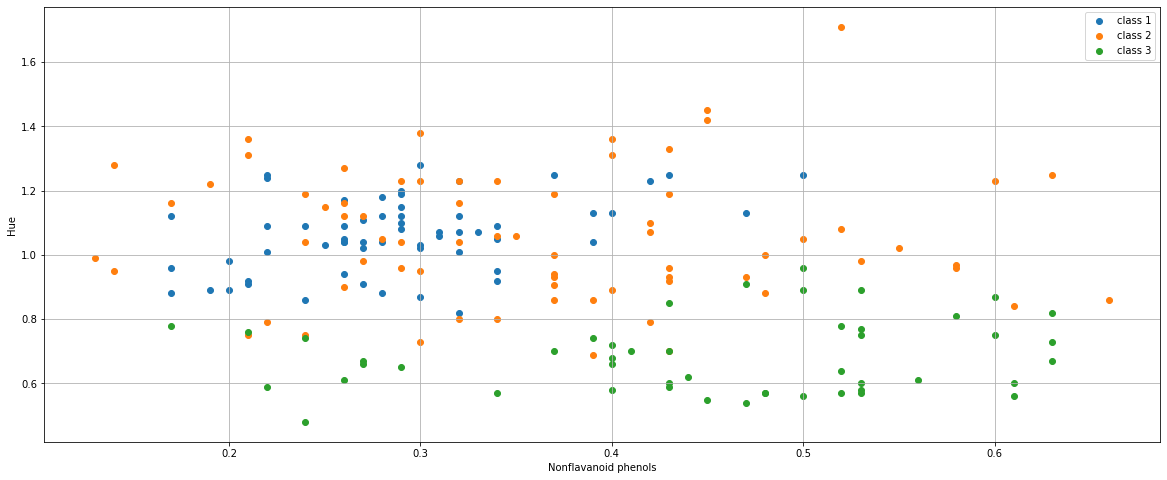

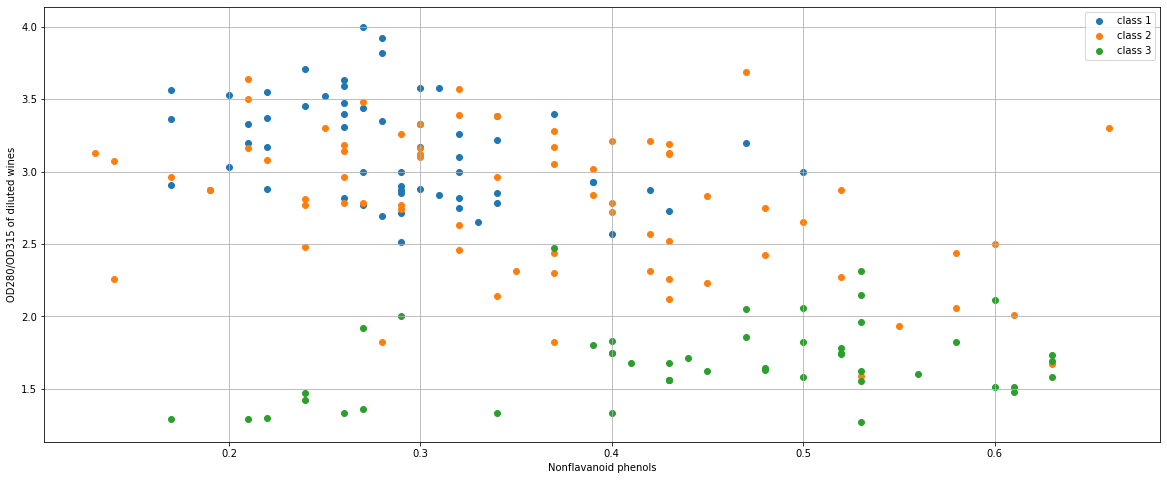

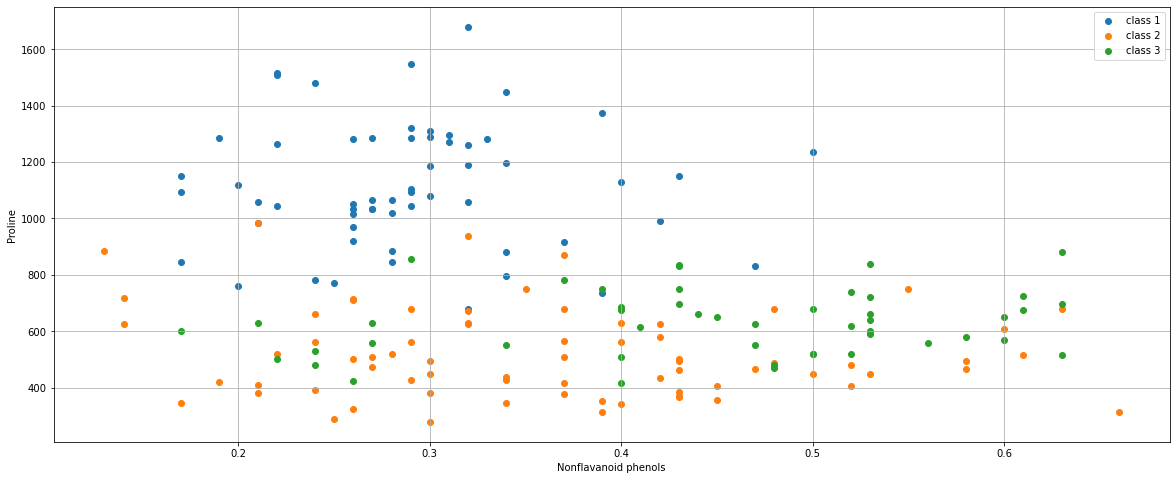

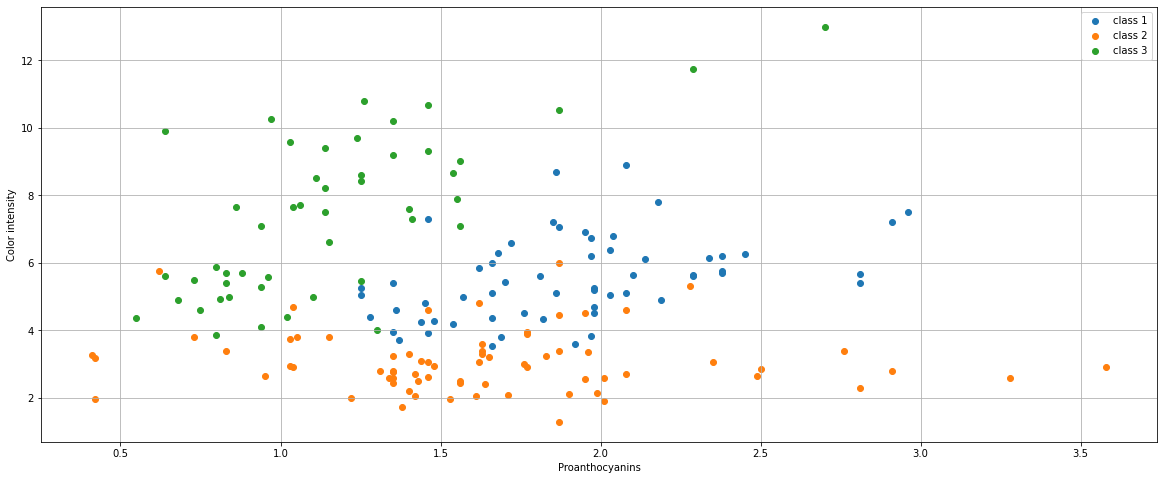

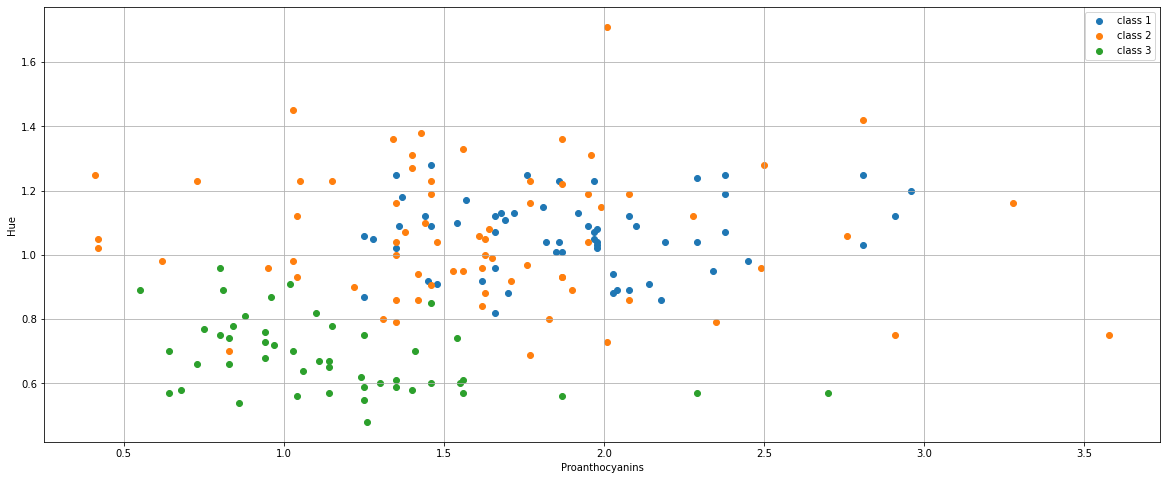

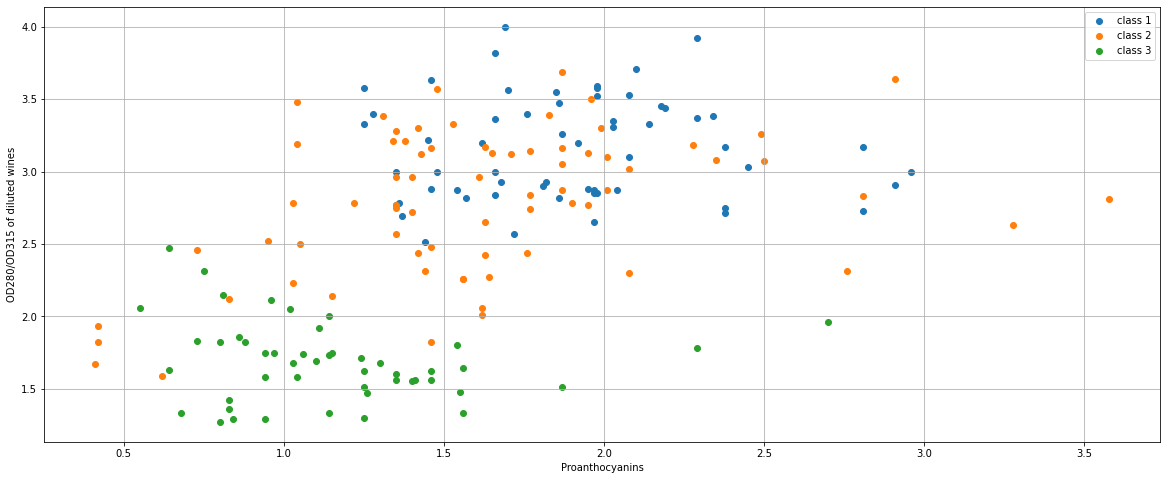

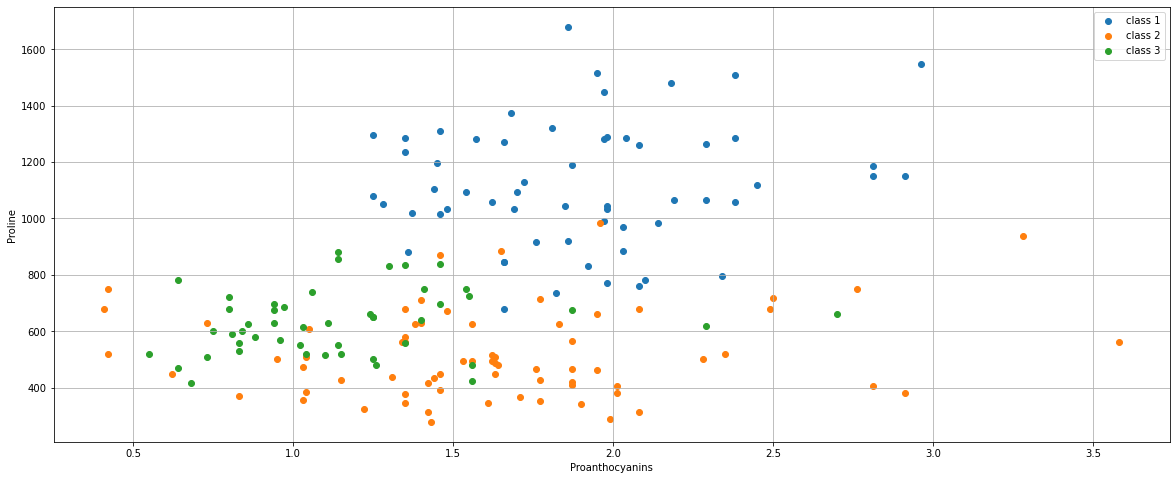

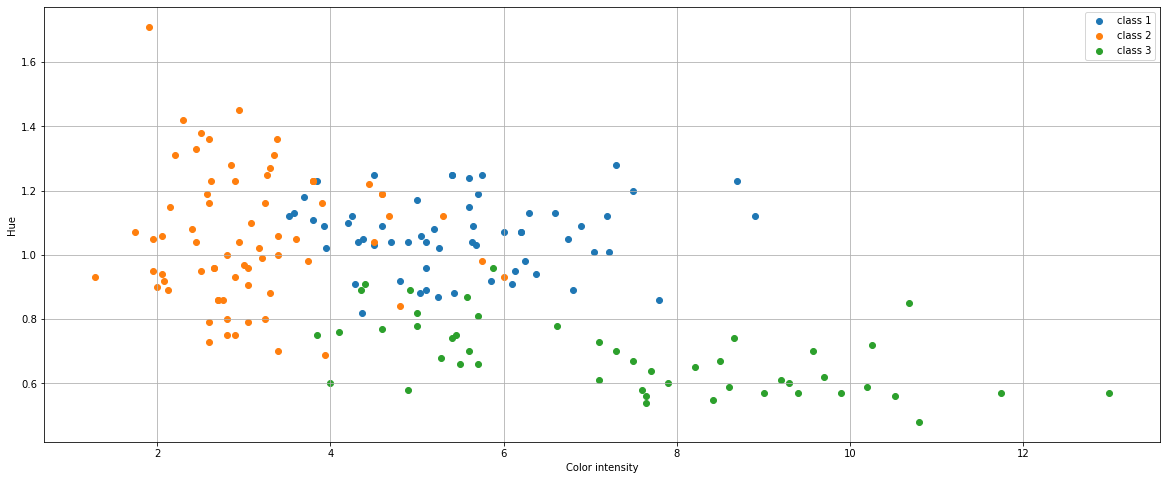

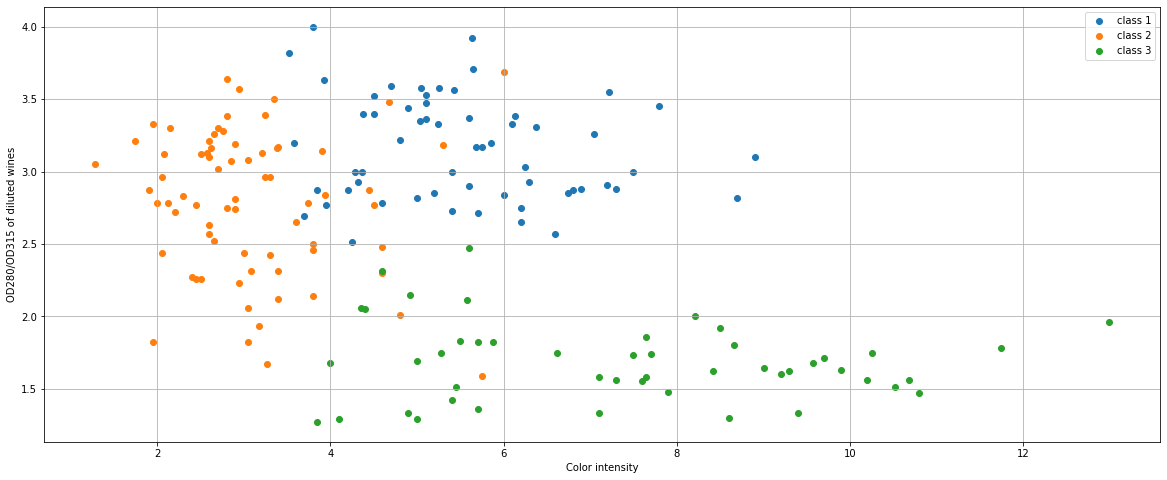

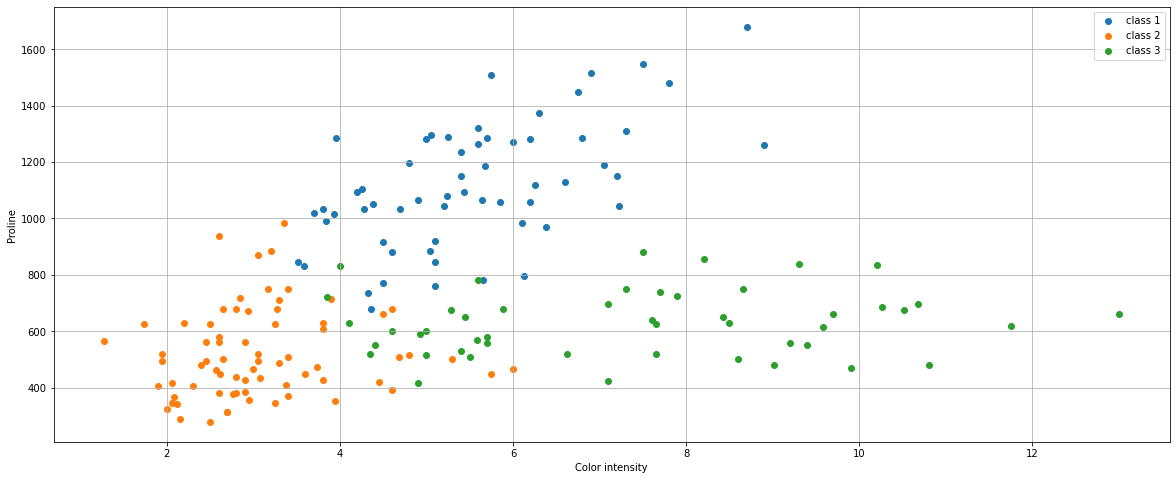

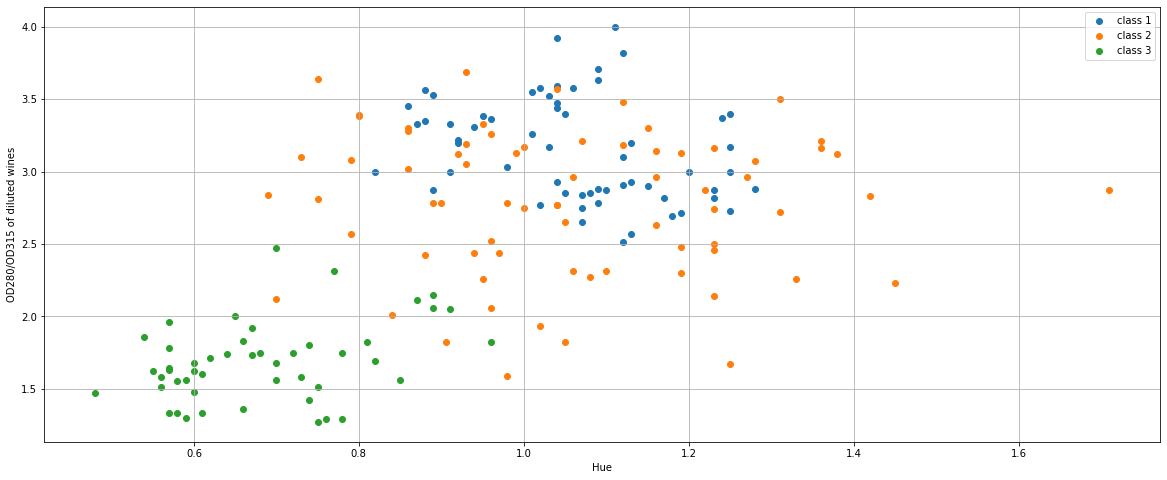

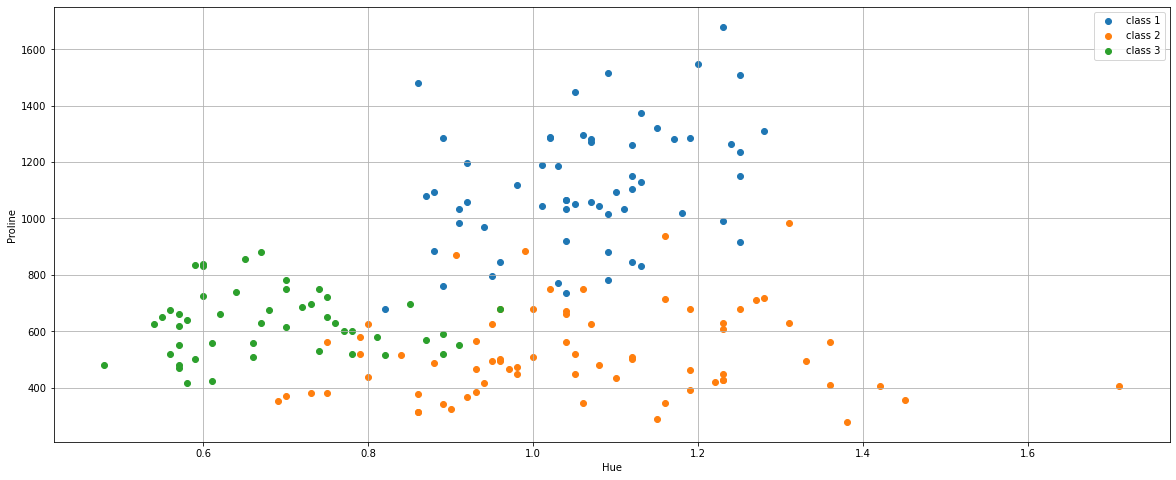

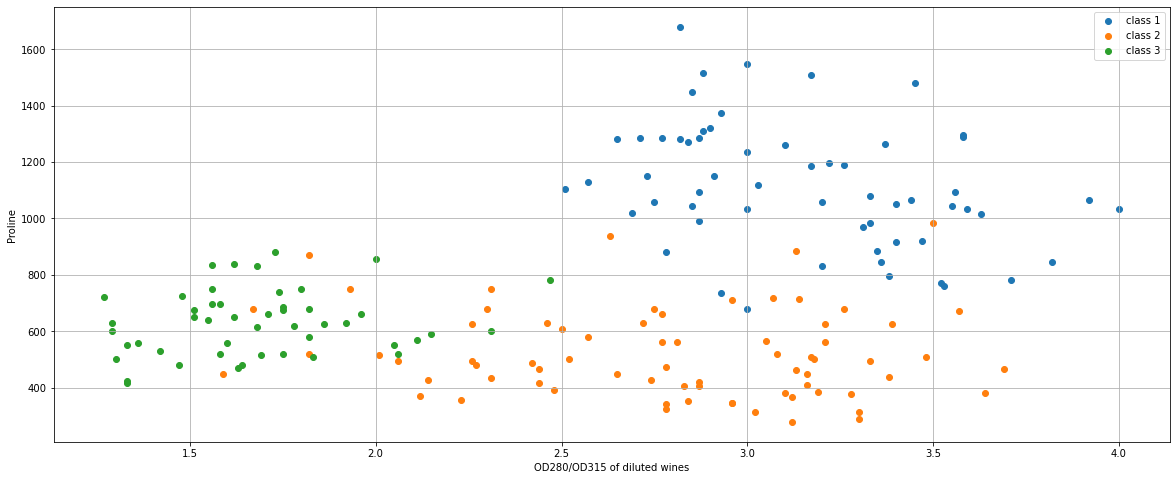

In [7]:
class1,class2,class3 = getClasses(dataset)
column = list(dataset)
column.pop(0)
for i in range(len(column)):
    for j in range(i,len(column)):
        # test si l'axe x est égale à l'axe y, dans ce cas, on passe à la suite.
        if(i == j):
            continue
        fig,axes = plt.subplots(sharex=True, figsize=(20, 8))
        axes.scatter(class1[column[i]],class1[column[j]])
        axes.scatter(class2[column[i]],class2[column[j]])
        axes.scatter(class3[column[i]],class3[column[j]])
        axes.legend(['class 1','class 2','class 3'])

        plt.grid(True)
        plt.xlabel(column[i])
        plt.ylabel(column[j])
        plt.show()

##### Analyse des graphes:
Nous avons relevé 6 graphiques avec des données bien distinctes. <br>
Il est apparu que c'est souvent les mêmes critères de filtrage qui font une démarcation notable.<br>
Voici donc la liste des graphes: 
    
| Axes X | Axes Y |
:---|:---|
| Alcohol | Flavanoids |
| OD280/OD315 of diluted wines | Alcohol |
| Flavanoids | Alcalinity of ash |
| color intensity | OD280/OD315 of diluted wines |
| flavanoids | prooline |
| color intensity | prooline |

##### Liste des catégories récurrentes: 

+ Alcohol

+ flavanoids

+ OD280/OD315 of diluted wines

+ prooline





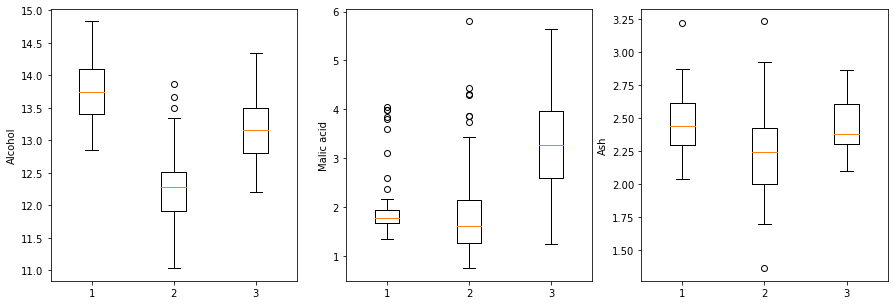

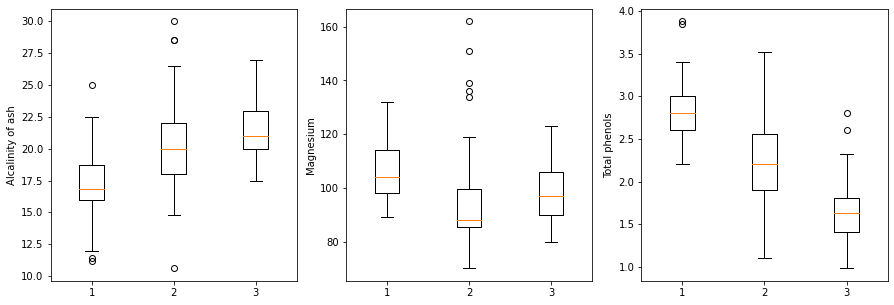

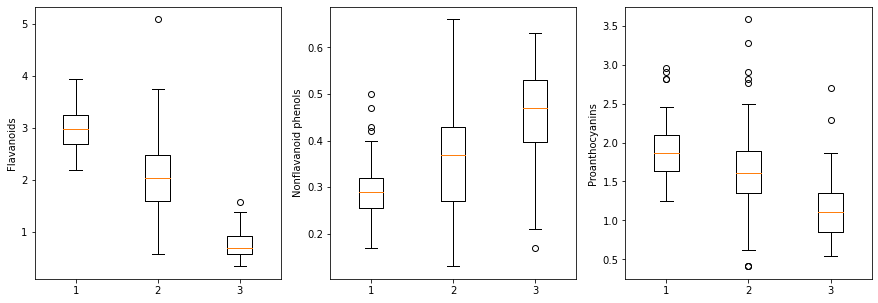

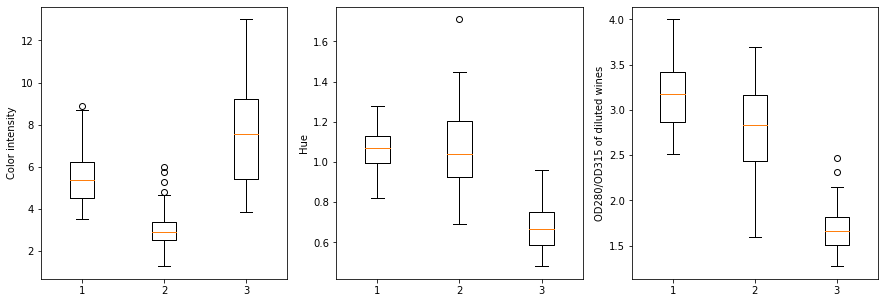

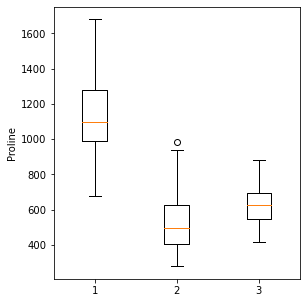

In [8]:
class1,class2,class3 = getClasses(dataset)
column = list(dataset)
column.pop(0)
for c in range(0, len(column), 3):
    fig,ax = plt.subplots(1,3, figsize=(15,5))
    for x in range(0,3):
        #On affiche 3x3 donc si il n'y a pas un multiple de 3 graphes, on cache les derniers.
        if (c+x >= len(column)) :
            ax[x].set_visible(False)
        else:
            ax[x].boxplot([class1[column[c+x]],class2[column[c+x]],class3[column[c+x]]],labels=(1,2,3))
            ax[x].set_ylabel(column[c+x])

##### Analyse point 1

En regardant de plus près les boxplots générées, on peut aperçevoir que les même critères de filtrage font à nouveau une démarquation notable (Q1 et Q3). c'est pratiquement les même que sur les scatters réalisés en dessus. 

+ Alcohol

+ Total phenols

+ flavanoids

+ color intensity

+ Proline              

## Exercie 2

### Modèle à base de règles

#### Exercice 2.a)
Test simple sans croisement de données. Essayez au moins trois variables de manière individuelle

Le code suivant va nous servir à tester quelles sont les valeurs hors norme pour les six classes définies ci-dessus. 

Voici le résonnement codé ci-dessous. 

1) Chercher la médiane intermédiaire entre les trois groupes

2) Lister les médianes par ordre croissant

3) Récupérer Q1 et Q3 en fonction de la médiane intermédiaire.

4) Vérifier pour toutes les valeurs si elles sont entre, au dessus ou en dessous de Q1 et Q3 de la médiane intermédiaire.

+ Si la valeur est entre Q1 et Q3, tester si elle appartient bien au groupe de la médiane intermédiaire.
+ Si la valeur est en dessous de Q1 tester si elle appartient bien au groupe de la médiane inférieur.   
+ Si la valeur est en dessus de Q3 tester si elle appartient bien au groupe de la médiane supérieur.
     
5) Compter le nombre de positif et négatif, puis faire le calcule d'accuracy. 

    
     Q1-1.5IQR   Q1   median  Q3   Q3+1.5IQR
     
                  |-----:-----|                  
      o  |--------|     :     |--------|    o  o
                  |-----:-----|
    flier         <----------->            fliers

                       IQR
https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.boxplot.html      

##### Teste simple sans croisement de données

In [9]:
class1,class2,class3 = getClasses(dataset)
column = list(dataset)
column.pop(0)

#Liste des variantes que nous voulons tester
sort_list = ["Alcohol","Total phenols", "Flavanoids", "Color intensity", "Proline" ,"OD280/OD315 of diluted wines"]
for c in range(0, len(column), 3):

    for x in range(0,3):
        #On affiche 3x3 donc si il n'y a pas un multiple de 3 graphes, on évite de sortir du tableau.
        if (c+x >= (len(column))) :
            continue
        if column[c+x] in sort_list :
            totalClass = []
            boxPlotDataSort = {}
            boxPlotDataSort[column[c+x]] = ax[x].boxplot([class1[column[c+x]],class2[column[c+x]],class3[column[c+x]]],labels=(1,2,3))
            totalClass.append(class1[column[c+x]])
            totalClass.append(class2[column[c+x]])               
            totalClass.append(class3[column[c+x]])
            #Pour chaque élément ajouté dans notre dictionaire
            for key, value in boxPlotDataSort.items():  
                print (key,":")
                #Création des variables d'incrémentation des varibles justes ou fausses 
                truePositive = 0
                trueNegative = 0  
                #Récupération des médiannes selon la classe
                data1 = (value["medians"][0].get_ydata())[0]
                data2 = (value["medians"][1].get_ydata())[0]
                data3 = (value["medians"][2].get_ydata())[0]
                #Ajouts de toutes les médiannes à la liste, puis la trier du plus petit au plus grand 
                mediansList = sorted([data1, data2, data3])
                dataTop = mediansList[-1]
                dataMiddle = sorted(mediansList)[1]
                #Test pour savoir quelle classe à la médianne intermédiaire des trois
                if dataMiddle == data1:
                    middleSelect = 0
                elif dataMiddle == data2:
                    middleSelect = 1
                elif dataMiddle == data3:
                    middleSelect = 2
                #Test pour savoir quelle classe à la médianne la plus élevée des trois
                if dataTop == data1:
                    topSelect = 0
                elif dataTop == data2:
                    topSelect = 1
                elif dataTop == data3:
                    topSelect = 2
                #Récupération de Q1 et de Q3 pour la classe avec la médianne moyenne.
                data = value["boxes"][middleSelect].get_ydata()
                data_min = float("{:.2f}".format(min(data)))
                data_max = float("{:.2f}".format(max(data)))
                #Permet de tester pour les trois classes
                for i in range(0, 3):
                    #Pour chacune des 178 valeurs du tableau
                    for y in totalClass[i]:
                        # Test pour savoir si les valeurs retournées sont dans la bonne classe ou non ? 
                        if(y > data_max):
                            if i == topSelect:
                                truePositive +=1 
                            else:
                                trueNegative +=1
                        elif(y > data_min and y < data_max):
                            if i == middleSelect:
                                truePositive +=1                                
                            else:
                                trueNegative +=1
                        else:
                            if i != middleSelect and i != topSelect:
                                truePositive +=1
                            else:
                                trueNegative +=1
                show_statistics(truePositive,trueNegative)
                    
                    
                    
                    

Alcohol :
 - True Positive :  126
 - True Negative :  52
 - Accuracy :  70.79 % 

Total phenols :
 - True Positive :  118
 - True Negative :  60
 - Accuracy :  66.29 % 

Flavanoids :
 - True Positive :  136
 - True Negative :  42
 - Accuracy :  76.4 % 

Color intensity :
 - True Positive :  122
 - True Negative :  56
 - Accuracy :  68.54 % 

OD280/OD315 of diluted wines :
 - True Positive :  110
 - True Negative :  68
 - Accuracy :  61.8 % 

Proline :
 - True Positive :  126
 - True Negative :  52
 - Accuracy :  70.79 % 



##### Teste avec croisement de données

#### Exercice 2.b)
Teste simple sans croisement de données

Utilisez les box plots des variables qui ont une majorité de valeurs différentes pour les différentes classes afin de programmer des règles (if then else) permettant la classification de chaque observation. a) Essayez au moins deux classificateurs à multiples variables (p.ex., deux ou trois) et évaluez le nombre d’observations qui sont correctement classées (accuracy) par ses moidèles.

In [10]:
wines_class_guessed = []
test_set_color = dataset['Color intensity']
test_set_flav = dataset['Flavanoids']
wines_actual_class = dataset['Class']
correct=0
wrong=0
for id,test_row_color in enumerate(test_set_color):
    if(test_row_color < 12 and test_set_flav[id] < 1.5):
        class_of_wine = '3'
    elif(test_row_color < 6 and test_set_flav[id] < 2.5):
        class_of_wine = '2'
    else:
        class_of_wine = '1'
    wines_class_guessed.append(class_of_wine)
    if int(wines_class_guessed[id]) == int(wines_actual_class[id]):
        correct +=1
    else:
        wrong +=1
show_statistics(correct,wrong)

 - True Positive :  140
 - True Negative :  38
 - Accuracy :  78.65 % 



In [11]:
wines_class_guessed = []
test_set_alcohol = dataset['Alcohol']
test_set_od = dataset['OD280/OD315 of diluted wines']
wines_actual_class = dataset['Class']
correct=0
wrong=0
for id,test_row_alcohol in enumerate(test_set_alcohol):
    if(test_row_alcohol < 13.1 and test_set_od[id] < 3.7 and test_set_od[id] > 2.0):
        class_of_wine = '2'
    elif(test_row_alcohol > 13.1 and test_set_od[id] > 2.5):
        class_of_wine = '1'
    else:
        class_of_wine = '3'
    wines_class_guessed.append(class_of_wine)
    if int(wines_class_guessed[id]) == int(wines_actual_class[id]):
        correct +=1
    else:
        wrong +=1
show_statistics(correct,wrong)

 - True Positive :  159
 - True Negative :  19
 - Accuracy :  89.33 % 



##### Analyse point 2

##### Evaluation du nombre d’observations:

On remarque qu'avec cette sélection nous avons quand même quelque chose d'assez précis et que la précision augmente avec le nombre de variable que nous utilisons. En croisant les données, non seulement nous dépassons toujours l'Accuracy trouvé lors des tests simples, mais en plus nous approchons des 90% d'accuracy ce qui ressemble fortement à un moyen de détecter la classification du vin avec seulement 10% d'erreur. <br> Il ne faut pas oublier qu'ici nous avons simplement croisé deux données. Si on décide d'en ajouter plus, le taux risque encore d'augmenter. 

## Exercie 3

### L’algorithme des k plus proches voisins (k NN)

#### Exercice 3.a)

#### Validation Hold-out 10x

Adaptez le code de k-NN vu en classe pour traiter le problème de classification des vins et testez la performance (accuracy) des modèles pour K=1,2,3,5,7,10. <br> 
Utilisez la méthode de validation hold out (calculez la moyenne d e performances en répétant le « split » 10 fois).

Moyenne de l'accuracy en validation Hold-out pour k =  1  :  85.77
Moyenne de l'accuracy en validation Hold-out pour k =  2  :  80.56
Moyenne de l'accuracy en validation Hold-out pour k =  3  :  86.34
Moyenne de l'accuracy en validation Hold-out pour k =  5  :  82.68
Moyenne de l'accuracy en validation Hold-out pour k =  7  :  79.01
Moyenne de l'accuracy en validation Hold-out pour k =  10  :  75.49


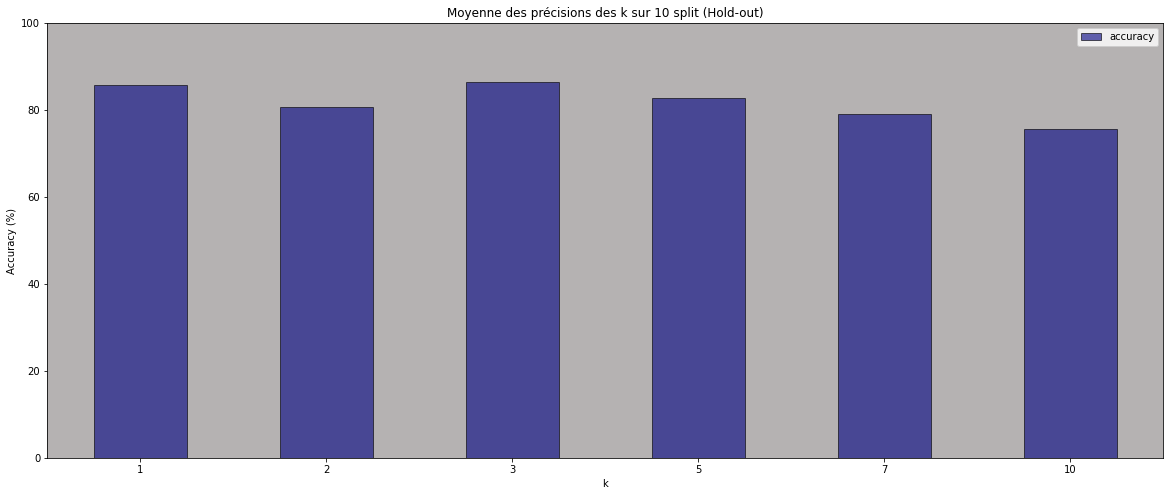

In [12]:
k_to_test = [1, 2, 3, 5, 7, 10]
validation_holdout_iteration = 10
accuracies_mean_hold = []

#Génération de la liste de X splits
for index, k in enumerate(k_to_test):
    
    accuracies = []
    for i in range(validation_holdout_iteration):
        
        #Passage de la fonction standard train_test_split 
        train_set, test_set = train_test_split(dataset.values.tolist())
        accuracy = calculate_accuracy(train_set, test_set, [wines[0] for wines in test_set], k, False)
        accuracies.append(accuracy)
        
    accuracies_mean_hold.append(np.array(accuracies).mean())
    print("Moyenne de l'accuracy en validation Hold-out pour k = ", k_to_test[index], " : ", float("{:.2f}".format(accuracies_mean_hold[index])))
    
plot_accuracy_bar("Moyenne des précisions des k sur 10 split (Hold-out)", k_to_test, accuracies_mean_hold)

#### Exercice 3.b)

#### Validation croisée avec n_folds = 5

Moyenne de l'accuracy en validation croisée pour k =  1  :  87.43  %
Moyenne de l'accuracy en validation croisée pour k =  2  :  81.71  %
Moyenne de l'accuracy en validation croisée pour k =  3  :  86.86  %
Moyenne de l'accuracy en validation croisée pour k =  5  :  86.29  %
Moyenne de l'accuracy en validation croisée pour k =  7  :  82.86  %
Moyenne de l'accuracy en validation croisée pour k =  10  :  79.43  %


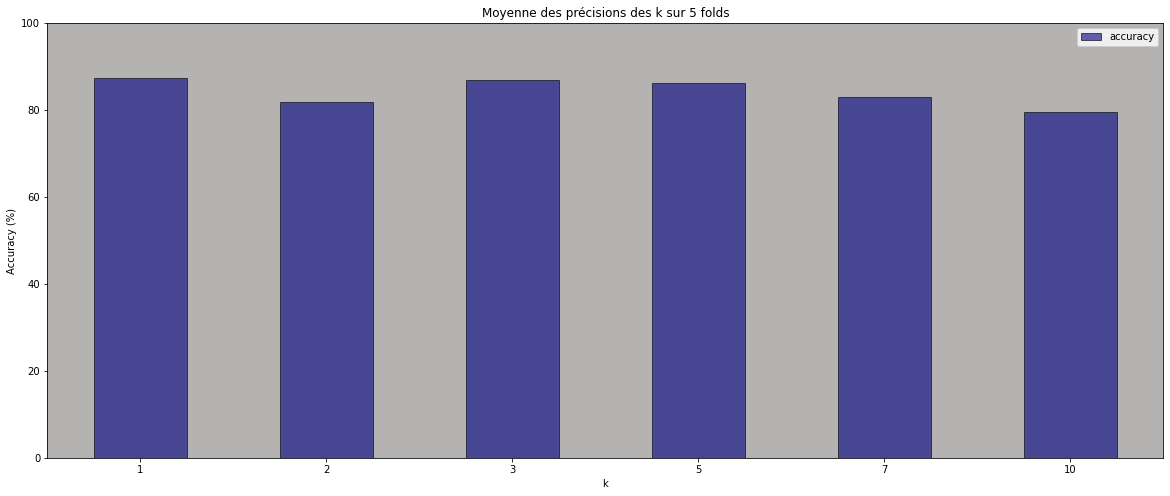

In [13]:
n_folds = 5
accuracies_mean_cross = []

for index, k in enumerate(k_to_test):
    
    predicted_values = []
    score = evaluate_algorithm_cross(dataset.values.tolist(), n_folds, k)
    predicted_values.append(score)
    accuracies_mean_cross.append(np.array(predicted_values).mean())
    print("Moyenne de l'accuracy en validation croisée pour k = ", k_to_test[index], " : ", float("{:.2f}".format(accuracies_mean_cross[index])), " %")

plot_accuracy_bar("Moyenne des précisions des k sur 5 folds", k_to_test, accuracies_mean_cross)

##### Analyse point 3
Présentez un résumé de vos résultats (c.a.d., un tableau avec les résultats ainsi qu’un plot ou bar chart) et commentez ceux ci.

On remarque dans un premier temps que les résultats sont très similaires entre une validation Hold-Out et une validation croisée, même si en général la validation croisée est un tout petit peu plus optimale.
Pour l'évaluation des modèles à réaliser ci-dessous, on a décidé de choisir un k étant égal à 3 car c'est à priori celui ayant le meilleur résultat et étant le moins sensibles à une variation. Un k étant égal à 1 aurait pu être envisagé, malheureusement celui-ci varie beaucoup selon les essaies réalisés précédemment.

## Exercie 4

### Évaluation des modèles

#### Utilisation de la bibliothèque scikit learn

Utilisez la bibliothèque scikit learn (sklearn.metrics) pour calculer la matrice de confusion du meilleur modèle trouvé précédemment (c.a.d., pour un K donné), sur l’ensemble de validation pour chaque « fold » de la validation croisée. <br>
Y a t il des classes pour lesque lles nous avons plus de peine à faire la bonne classification ?

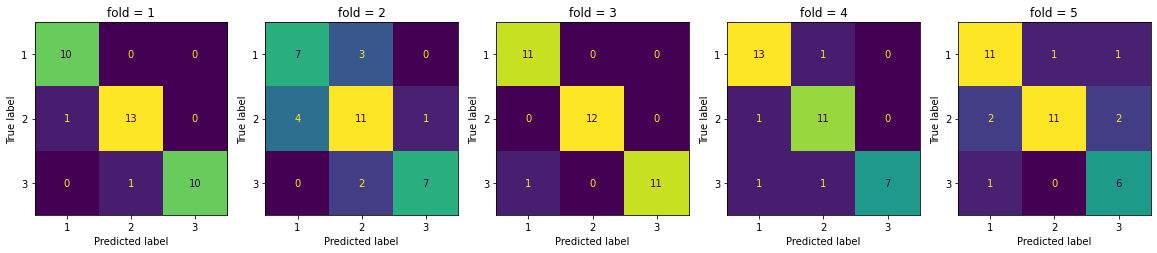

[94.28571428571428,
 71.42857142857143,
 97.14285714285714,
 88.57142857142857,
 80.0]

In [14]:
import sklearn.metrics as sk

# With precedent results we determine this k is the best one
best_accuracy_k = 3


evaluate_algorithm_cross(dataset.values.tolist(), n_folds, best_accuracy_k, True)

##### Analyse point 4
Y a-t-il des classes pour lesquelles nous avons plus de peine à faire la bonne classification ?

On remarque que la classe 2 est assez sensible, celle-ci est souvent assez majoritaire en termes de vrais positifs et de faux négatifs. Puis viendrait la classe 1 qui est la seconde étant la plus sensible et finalement la classe 3 qui est la moins sensible des 3 en termes d'erreurs.

## Exercie 5

### L’algorithme LVQ

Utilisez l’algorithme LVQ pour traiter le problème de classification des vins et testez la performance (accuracy) des modèles et calculez la matrice de confusion du meilleur modèle trouvé en explorant différentes valeurs de hyper paramètres (c.a.d., nombre de prototypes, learning rate et nombre d’epochs), sur l’ensemble de validation pour chaque « fold » de la validation croisée. Commentez vos résultats et comparez l’accuracy de ce modèle avec celle obtenu avec k-NN.

In [15]:
nfolds = 5
ncodebooks = 50
learning_rate = 0.5
nepochs = 50
mean_accuracies_lrate = []

# Normalizing data
wine_norm = normalize(dataset.loc[:, dataset.columns != 'Class'])
wine_norm = wine_norm.assign(Class=dataset['Class'])

print("Loading might be long, grab a cup of coffee !")

# Variation_learning_rate
variation_learning_rate = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

loader = Loader("1/3 - Loading variation_learning_rate ", "1/3 - variation_learning_rate \u2713", 0.05).start()
for i in variation_learning_rate:
    mean_accuracies_lrate.append(variation_parameters(nfolds, ncodebooks, i, nepochs))  
loader.stop()  


# Variation_n_codebooks
mean_accuracies_codebooks = []
variation_n_codebooks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

loader = Loader("2/3 - Loading variation_n_codebooks", "2/3 - variation_n_codebooks \u2713", 0.05).start()
for i in variation_n_codebooks:
    mean_accuracies_codebooks.append(variation_parameters(nfolds, i, learning_rate, nepochs))  
loader.stop()


# Variation_n_epochs
mean_accuracies_epochs = []
variation_n_epochs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

loader = Loader("3/3 - Loading variation_n_epochs", "3/3 - variation_n_epochs \u2713", 0.05).start()
for i in variation_n_epochs:
    mean_accuracies_epochs.append(variation_parameters(nfolds, ncodebooks, learning_rate, i))  
loader.stop()   


Loading might be long, grab a cup of coffee !
1/3 - variation_learning_rate ✓                                                                                         
2/3 - variation_n_codebooks ✓                                                                                           
3/3 - variation_n_epochs ✓                                                                                              


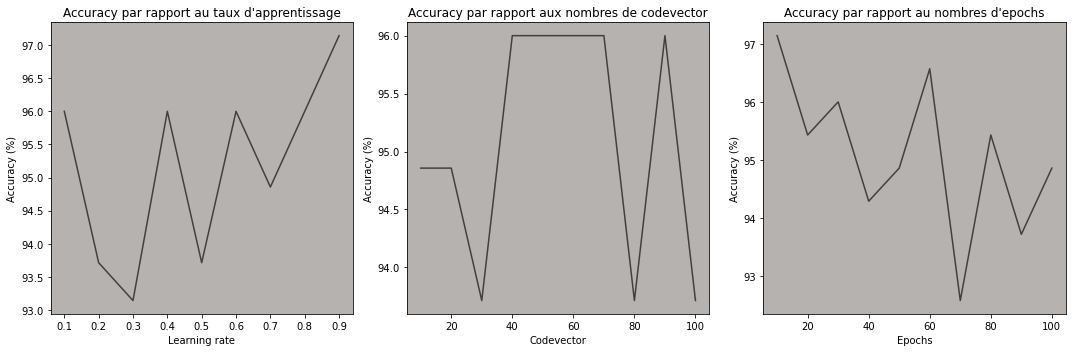

In [16]:
# Plotting results for the variation of the hyper-parameters

fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].plot(variation_learning_rate, mean_accuracies_lrate, color="#404040")
ax[0].set_xlabel('Learning rate')
ax[0].set_ylabel('Accuracy (%)')
ax[0].set_title('Accuracy par rapport au taux d\'apprentissage')
ax[0].set_facecolor(('#B5B2B0'))


ax[1].plot(variation_n_codebooks, mean_accuracies_codebooks, color="#404040")
ax[1].set_xlabel('Codevector')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title('Accuracy par rapport aux nombres de codevector')
ax[1].set_facecolor(('#B5B2B0'))


ax[2].plot(variation_n_epochs, mean_accuracies_epochs, color="#404040")
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Accuracy (%)')
ax[2].set_title('Accuracy par rapport au nombres d\'epochs')
ax[2].set_facecolor(('#B5B2B0'))

fig.tight_layout()
plt.show()

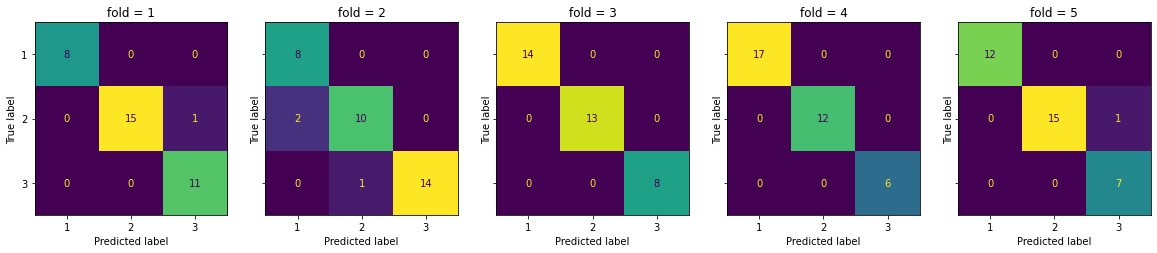

Moyenne de l'accuracy pour fold =  1  :  97.14  %
Moyenne de l'accuracy pour fold =  2  :  91.43  %
Moyenne de l'accuracy pour fold =  3  :  100.0  %
Moyenne de l'accuracy pour fold =  4  :  100.0  %
Moyenne de l'accuracy pour fold =  5  :  97.14  %


In [17]:
# These are the best hyper-parameters we discovered using the results above
nfolds = 5
ncodebooks = 60
learning_rate = 0.8
nepochs = 60

accuracies = evaluate_algorithm_LVQ(wine_norm.values.tolist(), nfolds, ncodebooks, learning_rate, nepochs, True)

for index, accuracy in enumerate(accuracies):
    print("Moyenne de l'accuracy pour fold = ", index + 1, " : ", float("{:.2f}".format(accuracy)), " %")

##### Analyse point 5
Commentez vos résultats et comparez l’accuracy de ce modèle avec celle obtenu avec k-NN.

Dans un premier temps, on peut discuter de la variation des différents paramètres. Il était assez compliqué d'évaluer les meilleurs paramètres étant donné que à chaque fois que l'on exécutait l'algorithme, les résultats étaient tout de même assez différents. Mais ce que l'on peut remarquer assez facilement, c'est que généralement les meilleurs paramètres sont ceux situer vers le milieu des plages proposées.

Dans un second temps, on peut évaluer l'accuracy obtenues et la comparer à k-NN. Pour rappel, les résultats de k-NN se situent entre ~75% - ~87% (ces deux valeurs étant des extrêmes). On remarque alors en moyenne un gain de ~10% sur l'accuracy. Dans les cas les plus extrêmes, cette valeur monte même jusqu'à 15% de gains.